In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import analysis.yinf as yinf
import analysis.products as products
import analysis.util as util
from data.util import *
import os, sys, re
from scipy.stats import gaussian_kde, linregress, binned_statistic
ML_DIR = os.path.expandvars("$SCRATCH/mlreco_cell/")
NETS = dict(enumerate(sorted([d for d in os.listdir(os.path.expandvars(ML_DIR))])))
SIM_DIR = os.path.expandvars("$SCRATCH/larsim/")
SIMS = dict(enumerate(sorted([d for d in os.listdir(os.path.expandvars(SIM_DIR)) if "reco" in d])))

"""
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]
"""

def parse_stats_dir(stats_dir = './stats'):
    stats_files = []
    for root, dirs, files in os.walk(stats_dir):
        rel_path = os.path.relpath(root, stats_dir)
        if rel_path.count('/') != 1: continue
        slash_i = rel_path.find('/')
        header = [rel_path[:slash_i], rel_path[slash_i+1:]]
        for f in files:
            epoch, _ = inf_file_info(f)
            thres = re.findall('thres([0-9]*[.]?[0-9]+)', f)
            if len(thres) == 1: 
                thres = float(thres[0])
            else:
                thres = -1
            stats_files.append(header+[epoch, thres, root+'/'+f])
    return pd.DataFrame(stats_files, columns=['net', 'inf', 'epoch', 'thres', 'file'])

STATS = parse_stats_dir().sort_values(by=['epoch'])

def select_stats(net=None, inf=None, thres=None, first=0, last=-1, stride=1, stats_df=STATS):
    if net is not None:
        stats_df = stats_df[stats_df.net==net]
    if inf is not None:
        stats_df = stats_df[stats_df.inf==inf]
    if thres is not None:
        stats_df = stats_df[stats_df.thres==thres]
    if last == -1:
        epochs = sorted(set(stats_df.epoch))[first::stride]
    else:
        epochs = sorted(set(stats_df.epoch))[first:last+1:stride]
    return list(stats_df[stats_df.epoch.isin(epochs)]['file'])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def plot_train_summary(*net_dirs, start_epoch = 1, noderange=(0, 1)):
    summaries = pd.DataFrame()
    for net_dir in net_dirs:
        print(net_dir)
        #summary = pd.read_csv(ML_DIR+net_dir+'/summaries_0.csv', delim_whitespace=True)
        summary = pd.concat([pd.read_csv(ML_DIR+net_dir+'/summaries_%d.csv'%i, delim_whitespace=True) for i in range(*noderange)])
        summary = summary[summary.epoch>=start_epoch]
        summary = summary.groupby(["epoch"]).mean()
        summaries[["train_loss: "+net_dir, "valid_loss: "+net_dir]] = summary[["train_loss", "valid_loss"]]
        try:
            summaries[["train_acc: "+net_dir, "valid_acc: "+net_dir]] = summary[["train_acc", "valid_acc"]]
        except:
            pass
        summaries[["train_time: "+net_dir, "valid_time: "+net_dir]] = summary[["train_time", "valid_time"]]
    summaries[[col for col in summaries.columns if '_loss' in col]].plot()
    try:
        summaries[[col for col in summaries.columns if '_acc' in col]].plot()
    except:
        pass
    summaries[[col for col in summaries.columns if '_time' in col]].plot()
    
def compute_yinf_stats(net_dir, xy_dir, start_epoch = 0, stride=1, tpc=None, evt_type=None, inf_dir="inference", **kwargs):
    stats_dir = "./stats/"+net_dir+'/'+inf_dir
    os.makedirs(stats_dir, exist_ok=True)
    print(net_dir)
    yinf_dir = ML_DIR+net_dir+'/'+inf_dir
    yinf_files = os.listdir(yinf_dir)
    if tpc is not None:
        yinf_files = [f for f in yinf_files if int(tpc_info(f)[0])==tpc]
    if evt_type is not None:
        yinf_files = [f for f in yinf_files if file_info(f)[0]==evt_type]
    yinf_epoch = files_info(yinf_files, [0], inf_file_info)
    n_epochs = len(yinf_epoch.keys())
    if start_epoch < 0:
        start_epoch += n_epochs
    for epoch in range(start_epoch, n_epochs, stride):
        yinf.yinf_avg_stats(epoch=epoch, tpc=tpc, evt_type=evt_type, stats_dir=stats_dir, xy_dir=SIM_DIR+xy_dir, yinf_dir=yinf_dir, **kwargs)

def find_n_last(text, pattern, n):
    if n==1: return text.rfind(pattern)
    return find_n_last(text[:text.rfind(pattern)], pattern, n-1)

def plot_yinf_stats(*stats_files):
    stats_files = np.concatenate(stats_files)
    labels = [f[find_n_last(f, '/', 3)+1:f.rfind('.')] for f in stats_files]
    yinf.compare_yinf_stats(plt.figure(), stats_files, labels)
    
def plot_mc_stats(stats_file, tpc=None, beamcosmic=None, pdg_ids=None):
    if isinstance(stats_file, list):
        if tpc is None:
            stats_file = list(stats_file)[0]
        else:
            stats_file = [f for f in stats_file if "tpc%d_stats"%tpc in f][0]
    print(stats_file)
    def filter_mc(mc):
        if pdg_ids is not None and mc[1] not in pdg_ids: return False
        if beamcosmic is not None and mc[4]!=beamcosmic: return False
        return True
    yinf.plot_mc_stats(plt.figure(), plt.figure(), plt.figure(), filter_mc, stats_file)
    
def plot_mc(xy_dir, mc_beamcosmic_dir=None, file_i=0, tpc=1, event=0, min_size=30, pdg_ids=None, beamcosmic=None, plot_all=True, stats_file=None):
    xy_dir = SIM_DIR+xy_dir
    if mc_beamcosmic_dir is not None:
        mc_beamcosmic_dir = SIM_DIR+mc_beamcosmic_dir
    xy_file = sorted([f for f in os.listdir(xy_dir) if tpc_info(f)[0]==tpc])[file_i]
    def filter_mc(mc):
        if mc[2] < min_size: return False
        if pdg_ids is not None and mc[1] not in pdg_ids: return False
        if beamcosmic is not None and mc[4]!=beamcosmic: return False
        return True
    products.plot_mc(plt.figure(), event, filter_mc, plot_all, mc_beamcosmic_dir, stats_file, xy_dir+'/'+xy_file)

def plot_yinf(figs, net_dir, xy_dir, epoch = -1, file_i=0, tpc=None, evt_type=None, event = 0, downsample=(1,1,1), thres=None, true_thres=0, plot_slice=False, plot_lims=None, view_angle=None, inf_dir="inference"):
    fig, fig_hist, fig_inf, fig_hist_inf, fig_true, fig_true_hist, fig_true_inf, fig_true_hist_inf= figs
    yinf_dir = ML_DIR+net_dir+'/'+inf_dir
    yinf_files = os.listdir(yinf_dir)
    if tpc is not None:
        yinf_files = [f for f in yinf_files if int(tpc_info(f)[0])==tpc]
    if evt_type is not None:
        yinf_files = [f for f in yinf_files if file_info(f)[0]==evt_type]
    yinf_epoch = files_info(yinf_files, [0], inf_file_info)
    epoch_i = sorted(yinf_epoch.keys())[epoch]
    yinf_file = sorted([f for f in yinf_epoch[epoch_i] if tpc is None or tpc_info(f)[0]==tpc])[file_i]
    plot_lims, thres = yinf.plot_yinf(fig, fig_hist, fig_inf, fig_hist_inf, 
                                      event, downsample, thres, true_thres, 
                                      plot_slice, plot_lims, view_angle, SIM_DIR+xy_dir, yinf_dir+'/'+yinf_file)
    products.compare_true_active(fig_true, fig_true_hist,  fig_true_inf, fig_true_hist_inf, 
                                 event, downsample, true_thres, 
                                 plot_slice, plot_lims, view_angle, yinf.get_xy_file(SIM_DIR+xy_dir, yinf_file))
    x_lim, y_lim, z_lim = plot_lims
    return x_lim, y_lim, z_lim, thres

def plot_true_v_inf(net_dir, xy_dir, epoch = -1, file_i=0, event = 0, inf_dir="inference"):
    yinf_dir = ML_DIR+net_dir+'/'+inf_dir
    yinf_epoch = files_info(os.listdir(yinf_dir), [0], inf_file_info)
    epoch_i = sorted(yinf_epoch.keys())[epoch]
    yinf_file = yinf_dir +'/'+ sorted(yinf_epoch[epoch_i])[file_i]
    print(yinf_file)
    xy_file = yinf.get_xy_file(SIM_DIR+xy_dir, yinf_file)
    
    voxel_truth, voxel_active, event_info = products.parse_xy(event, 1, xy_file)
    voxel_yinf = yinf.parse_yinf(event_info, yinf_file)
    _, intersect, FP = util.comp_voxels(voxel_truth, voxel_active, True)
    
    vals_T_active = np.array([[voxel_truth[coord], voxel_yinf[coord]] for coord in intersect])
    vals_ghosts = np.array([[-1, voxel_yinf[coord]] for coord in FP]).T
    dens_ghosts = gaussian_kde(vals_ghosts)(vals_ghosts)
    fig, axes = plt.subplots(2)
    ax, ax2 = axes
    ax.scatter(*vals_T_active.T, s=1)
    ax.scatter(*vals_ghosts, c = dens_ghosts, s=1)
    ax.set_xlabel("True Energy [MeV]")
    ax.set_title("Inference vs Energy")
    
    vals_T_active = np.array([[voxel_truth[coord], voxel_active[coord]] for coord in intersect])
    vals_ghosts = np.array([[-1, voxel_active[coord]] for coord in FP]).T
    dens_ghosts = gaussian_kde(vals_ghosts)(vals_ghosts)
    ax2.scatter(*vals_T_active.T, s=1)
    ax2.scatter(*vals_ghosts, c = dens_ghosts, s=1)
    ax2.set_xlabel("True Energy [MeV]")
    ax2.set_title("Pixel value vs Energy")
    
    fig.suptitle("Energy Scatter \nInference file: %s, Event: %d"%(yinf_file[yinf_file.rfind('/')+1:], event))

class PlotYinfWidget():   
    def __init__(self, out, **kwargs):
        if kwargs.get("event") is None:
            kwargs["event"] = 0
        self.view_angle = kwargs["view_angle"]
        kwargs["plot_slice"] = False
        self.figs = [plt.figure() for _ in range(8)]
        self.sigmoid=kwargs.pop("sigmoid", True)
        kwargs["figs"] = self.figs
        self.Size = self.figs[0].get_size_inches() 
        self.kwargs = kwargs
        self.out = out
    def get_widgets(self):
        bnext = widgets.Button(description='Next')
        bprev = widgets.Button(description='Previous')
        bset = widgets.Button(description='Set')
        breset = widgets.Button(description='Reset')
        bnext.on_click(callback.next)
        bprev.on_click(callback.prev)
        bset.on_click(callback.set)
        breset.on_click(callback.reset)
        self.xmin = widgets.IntSlider(
             step=1,
             description='xmin')
        self.xmax = widgets.IntSlider(
             step=1,
             description='xmax')
        self.ymin = widgets.IntSlider(
             step=1,
             description='ymin')
        self.ymax = widgets.IntSlider(
             step=1,
             description='ymax')
        self.zmin = widgets.IntSlider(
             step=1,
             description='zmin')
        self.zmax = widgets.IntSlider(
             step=1,
             description='zmax')
        self.thres = widgets.FloatSlider(
             min=0 if self.sigmoid else -10,
             max=1.0 if self.sigmoid else 10,
             step=0.01,
             description='threshold')
        self.elev = widgets.FloatSlider(
             value=self.view_angle[0],
             min=-90,
             max=90,
             step=1,
             description='elevation')
        self.azim = widgets.FloatSlider(
             value=self.view_angle[1],
             min=-90,
             max=90,
             step=1,
             description='azimuth')
        self.slice = widgets.Checkbox(
            value=False,
            description='2D slice')
        self.slice_invert = widgets.Checkbox(
            value=False,
            description='inverted 2D axis')
        self.plots = [widgets.Checkbox(
            value=True,
            description='Fig %d'%(i+self.figs[0].number)) for i in range(8)]
        self._plot_event()
        return bnext, bprev, bset, breset, \
            self.xmin, self.xmax, self.ymin, self.ymax, self.zmin, self.zmax, \
            self.thres, self.elev, self.azim, self.slice, self.slice_invert, self.plots
            
    def next(self, event):
        self.kwargs["event"] += 1
        self._clear_vals()
        self._plot_event() 
    def prev(self, event):
        if self.kwargs["event"]>0:
            self.kwargs["event"] -= 1
        self._clear_vals()
        self._plot_event()
    def set(self, event):
        self._read_vals()
        self._plot_event()
    def reset(self, event):
        self._clear_vals(True)
        self._plot_event()
    
    def _plot_event(self):
        for fig in self.figs:
            fig.clf()
        if not self.slice.value:
            self.xmin.max=self.xmax.max=10000
            self.xmin.min=self.xmax.min=-10000
        self.ymin.max=self.ymax.max=self.zmin.max=self.zmax.max=10000
        self.ymin.min=self.ymax.min=self.zmin.min=self.zmax.min=-10000
        with self.out:
            clear_output()
            defaults = plot_yinf(**self.kwargs)
            if self.slice.value:
                self.xmax.value = defaults[0][1]
                self.xmin.value = defaults[0][0]
            else:
                self.xmin.max=self.xmax.max=self.xmax.value =defaults[0][1]
                self.xmin.min=self.xmax.min=self.xmin.value =defaults[0][0]
            self.ymin.max=self.ymax.max=self.ymax.value = defaults[1][1]
            self.ymin.min=self.ymax.min=self.ymin.value = defaults[1][0]
            self.zmin.max=self.zmax.max=self.zmax.value = defaults[2][1]
            self.zmin.min=self.zmax.min=self.zmin.value = defaults[2][0]
            self.thres.value = defaults[3]
            self.kwargs["plot_lims"] = defaults[:3]
            self.kwargs["thres"] = defaults[3]

    def _read_vals(self):
        if self.slice.value and (self.kwargs["plot_lims"][0][0] != self.xmin.value or self.kwargs["plot_lims"][0][1] != self.xmax.value):
            if self.kwargs["plot_lims"][0][0] != self.xmin.value:
                self.xmax.value = self.xmin.value+1
            self.kwargs["plot_lims"] = ((self.xmin.value, self.xmax.value), None, None)
        else:
            self.kwargs["plot_lims"] = ((self.xmin.value, self.xmax.value),
                                        (self.ymin.value, self.ymax.value),
                                        (self.zmin.value, self.zmax.value))
        if self.thres.value != self.kwargs["thres"] or self.kwargs["plot_slice"] != self.slice.value:
            if self.slice.value:
                self.kwargs["plot_lims"] = ((self.xmin.value, self.xmax.value), None, None)
            else:
                self.kwargs["plot_lims"] = None
                
        self.kwargs["plot_slice"] = self.slice.value        
        self.kwargs["thres"] = self.thres.value
        if self.slice.value:
            self.kwargs["view_angle"] = not self.slice_invert.value
        else:
            self.kwargs["view_angle"] = (self.elev.value, self.azim.value)
        self.kwargs["figs"] = [fig if plot.value else None for fig, plot in zip(self.figs, self.plots)]
        for fig, plot in zip(self.figs, self.plots):
            if plot.value:
                fig.set_size_inches(self.Size[0]*1.5, self.Size[1]*1.2, forward=True)
            else:
                fig.set_size_inches(self.Size[0]/3, self.Size[1]/3, forward=True)
    def _clear_vals(self, reset=False):
        if reset and self.slice.value:
            self.kwargs["plot_lims"] = ((self.xmin.value, self.xmax.value), None, None)
            self.kwargs["view_angle"] = not self.slice_invert.value
        else:
            self.slice.value = self.kwargs["plot_slice"] = False
            self.kwargs["plot_lims"] = None
        self.kwargs["thres"] = None
        if self.slice.value:
            self.kwargs["view_angle"] = not self.slice_invert.value
        else:
            self.elev.value, self.azim.value = self.kwargs["view_angle"] = self.view_angle
        self.kwargs["figs"] = [fig if plot.value else None for fig, plot in zip(self.figs, self.plots)]
        for fig, plot in zip(self.figs, self.plots):
            if plot.value:
                fig.set_size_inches(self.Size[0]*1.5, self.Size[1]*1.2, forward=True)
            else:
                fig.set_size_inches(self.Size[0]/3, self.Size[1]/3, forward=True)


In [ ]:
NETS

In [ ]:
SIMS

In [ ]:
net = 'sparse_singleElectronHit_ghost2D_1652'
plot_train_summary(net)
compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir="inference2")
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0, n_yinf_files=5)
plot_yinf_stats(select_stats(net, "inference", 0.5, -2, stride = 2),  select_stats(net, "inference2"))

In [ ]:
net = 'singleElectronHit_ghost2D_1652-rep4'
plot_train_summary(net)
compute_yinf_stats(net, SIMS[0], 1, true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')
compute_yinf_stats(net, SIMS[0], 1, true_thres=0, n_yinf_files=5, inf_dir='inf_train')
plot_yinf_stats(select_stats(net, "inference", 0.5, stride = 2),  select_stats(net, "inf_train"))


In [ ]:
net = 'singleElectronHit_ghost2D_1652-rep4_L1-2'
plot_train_summary(net, 5)
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')

plot_yinf_stats(select_stats(net, "inf_train", 0.5))
plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2))
plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2), select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5, stride = 4), 
                select_stats(net, "inference", 0, stride = 4), 
                select_stats(net, "inf_train"))

In [ ]:
net = 'singleElectronHit_ghost3D-164'
plot_train_summary(net, 5)
#compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2), select_stats(net, "inf_train"))


out = widgets.Output()
callback = PlotYinfWidget(out, net_dir=net, xy_dir=SIMS[0], true_thres=0.5, view_angle=(0,90), inf_dir='inference')
bnext, bprev, bset, breset, xmin, xmax, ymin, ymax, zmin, zmax, thres, elev, azim, slic, plots = callback.get_widgets()
bs = widgets.HBox([bprev, bnext, bset, breset])
plots_inf = widgets.HBox(plots[:4])
plots_active = widgets.HBox(plots[4:])
viewangle = widgets.HBox([elev, azim])
x_lims = widgets.HBox([xmin, xmax, slic])
y_lims = widgets.HBox([ymin, ymax])
z_lims = widgets.HBox([zmin, zmax])
widgets.VBox([bs, plots_inf, plots_active, thres, viewangle, x_lims, y_lims, z_lims, out])

In [ ]:
net = 'singleElectronHit_ghost3D-164_L1-1'
plot_train_summary(net, 5)
#compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')
compute_yinf_stats(net, SIMS[0], 1, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[0], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5,  -5, stride = 1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, stride = 1), select_stats(net, "inf_train"))

In [ ]:
net = 'singleElectronHit_ghost3D-164_L1-3'
plot_train_summary(net, 8)
#compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')
#compute_yinf_stats(net, SIMS[0], 1, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5, -10, stride = 2))
#plot_yinf_stats(select_stats(net, "inference", 0.5, stride = 1), select_stats(net, "inf_train"))

In [ ]:
net = 'singleElectronWire_ghost3D-164'
plot_train_summary(net, 20)
#compute_yinf_stats(net, SIMS[4], true_thres=0.5, n_yinf_files=5, inf_dir='inf_muhit')
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -1), select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))

out = widgets.Output()
callback = PlotYinfWidget(out, net_dir=net, xy_dir=SIMS[1], true_thres=0.5, view_angle=(0,90), inf_dir='inference')
bnext, bprev, bset, breset, xmin, xmax, ymin, ymax, zmin, zmax, thres, elev, azim, slic, plots = callback.get_widgets()
bs = widgets.HBox([bprev, bnext, bset, breset])
plots_inf = widgets.HBox(plots[:4])
plots_active = widgets.HBox(plots[4:])
viewangle = widgets.HBox([elev, azim])
x_lims = widgets.HBox([xmin, xmax, slic])
y_lims = widgets.HBox([ymin, ymax])
z_lims = widgets.HBox([zmin, zmax])
widgets.VBox([bs, plots_inf, plots_active, thres, viewangle, x_lims, y_lims, z_lims, out])

In [ ]:
net = 'singleElectronWire_ghost3D-164_WeightedCE'
#plot_train_summary(net, 0)
#compute_yinf_stats(net, SIMS[4], true_thres=0.5, n_yinf_files=5, inf_dir='inf_muhit')
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -1), select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))
out = widgets.Output()
callback = PlotYinfWidget(out, net_dir=net, xy_dir=SIMS[1], true_thres=0.5, view_angle=(0,90), inf_dir='inference')
bnext, bprev, bset, breset, xmin, xmax, ymin, ymax, zmin, zmax, thres, elev, azim, slic, plots = callback.get_widgets()
bs = widgets.HBox([bprev, bnext, bset, breset])
plots_inf = widgets.HBox(plots[:4])
plots_active = widgets.HBox(plots[4:])
viewangle = widgets.HBox([elev, azim])
x_lims = widgets.HBox([xmin, xmax, slic])
y_lims = widgets.HBox([ymin, ymax])
z_lims = widgets.HBox([zmin, zmax])
widgets.VBox([bs, plots_inf, plots_active, thres, viewangle, x_lims, y_lims, z_lims, out])

In [ ]:
net = 'singleElectronWire_ghost3D-164_WeightedCE2'
plot_train_summary(net, start_epoch=0)
#compute_yinf_stats(net, SIMS[4], true_thres=0.5, n_yinf_files=5, inf_dir='inf_muhit')
compute_yinf_stats(net, SIMS[1], 5, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -1), select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))


In [ ]:
net = 'singleElectronWire_ghost3D-164_WeightedCE-1'
plot_train_summary(net, 0)
#compute_yinf_stats(net, SIMS[4], true_thres=0.5, n_yinf_files=5, inf_dir='inf_muhit')
compute_yinf_stats(net, SIMS[1], 10, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -1), select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))



In [ ]:
net = 'singleElectronWire_ghost3D-164_LabelWeightedCE-10'
plot_train_summary(net,'singleElectronWire_ghost3D-164')
#compute_yinf_stats(net, SIMS[4], true_thres=0.5, n_yinf_files=5, inf_dir='inf_muhit')
compute_yinf_stats(net, SIMS[1], -1, stride=1, true_thres=0., n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5, -1, stride = 1), select_stats('singleElectronWire_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", 0.5, -1), select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))


In [ ]:
net = 'singleElectronWire-30k_ghost3D-164'
#plot_train_summary(net, start_epoch=20)
#compute_yinf_stats(net, SIMS[4], true_thres=0.5, n_yinf_files=5, inf_dir='inf_muhit')
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -1), select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))

#plot_true_v_inf(net, SIMS[1], epoch = -1, file_i=0, event = 0, inf_dir="inference")

In [ ]:
net = 'singleElectronWire-downsample(4,2,2)-lr0.01_ghost3D-164'
plot_train_summary(net, start_epoch=1)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
compute_yinf_stats(net, SIMS[1], -1, T_weighted=False, stride=1, true_thres=0.5, n_yinf_files=1, inf_dir='inference')
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

plot_yinf_stats(select_stats(net, "inference", first=-1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", first=-1),  select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))


In [ ]:
net = 'singleElectronWire-downsample(4,2,2)v3_ghost3D-165-LabelWeighted10-p0.9'
plot_train_summary(net, start_epoch=3)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
#compute_yinf_stats(net, SIMS[1], -1, T_weighted=False, stride=1, true_thres=0.5, n_yinf_files=1, inf_dir='inf_train')
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

plot_yinf_stats(select_stats(net, "inference", first=-3))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", first=-1),  select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))


In [ ]:
net = 'singleElectronWire-downsample(4,2,2)-1_ghost3D-164-conv7-lr0.01-labelweighted10-p0.9'
#plot_train_summary(net, start_epoch=3)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
compute_yinf_stats(net, SIMS[1], -1, T_weighted=False, stride=1, true_thres=0.5, n_yinf_files=1, inf_dir='inf_train')
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

plot_yinf_stats(select_stats(net, "inf_train", first=-1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
#plot_yinf_stats(select_stats(net, "inference", first=-1),  select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))


In [ ]:
net = 'singleE-BeamCosmic_ghost3D-164-lr0.01'
plot_train_summary(net, start_epoch=0)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
#compute_yinf_stats(net, SIMS[9], -1, T_weighted=False, stride=1, true_thres=0.5, n_yinf_files=3, inf_dir='inference')

#compute_yinf_stats(net, SIMS[9], -1, stride=1, true_thres=0.5, n_yinf_files=10,  n_events=50, evt_type='Electron')
#compute_yinf_stats(net, SIMS[1], -1, stride=1, true_thres=0.17, n_yinf_files=100,  n_events=5, tpc=9, evt_type='BeamCosmic')
#compute_yinf_stats(net, SIMS[1], -1, stride=1, true_thres=0.17, n_yinf_files=100,  n_events=5, tpc=5, evt_type='BeamCosmic')
#compute_yinf_stats(net, SIMS[1], -3, stride=1, true_thres=0.17, n_yinf_files=100,  n_events=5, tpc=1, evt_type='BeamCosmic')

#plot_yinf_stats(select_stats(net, "inference"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", first=-5, last=-2),  select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))

plot_yinf_stats(select_stats('singleElectronWire-v3_3-25k_ghost3D-164-lr0.01', "inference", first=0, last=-1))

In [ ]:
plot_yinf_stats(select_stats('singleElectronWire-downsample(4,2,2)-1_ghost3D-164-conv5-p0.9', "inf_train", first=-1),
               select_stats('singleElectronWire-downsample(4,2,2)v2-1_ghost3D-165-LabelWeighted-10-lr0.01-p0.9', "inf_train", first=-1),
               #select_stats('singleElectronWire-downsample(4,2,2)v3-1_ghost3D-165-LabelWeighted10-lr0.01-p0.9', "inf_train", first=-1),
               select_stats('singleElectronWire-downsample(4,2,2)v3-1_ghost3D-165-LabelWeighted10-p0.9', "inf_train", first=-1),)
               #select_stats('singleElectronWire-downsample(4,2,2)v3-1_ghost3D-165-LabelWeighted100-p0.9', "inf_train", first=-1),
               #select_stats('singleElectronWire-v3-1_ghost3D-165-lr0.01', "inf_train", first=-1),
               #select_stats('singleElectronWire-v3_3-1_ghost3D-165-lr0.01', "inf_train", first=-1),)

plot_yinf_stats(select_stats('singleElectronWire-downsample(4,2,2)v2_ghost3D-165-LabelWeighted10-p0.9', "inference", first=-1),
               select_stats('singleElectronWire-downsample(4,2,2)v3_ghost3D-165-LabelWeighted10-p0.9', "inference", first=-1, last=-1),
               select_stats('singleElectronWire-downsample(4,2,2)_ghost2D-1651-p0.9', "inference", first=-1),
               select_stats('singleElectronWire-v3-3_ghost3D-164_LabelWeightedCE-10-lr0.01', 'inference', 0.5, -1, -1))

In [ ]:
#plot_mc_stats('./stats/singleElectronWire-v3_3-25k_ghost3D-164-lr0.01/inf_cosmic/epoch59_stats-thres0.17-N300-v2.npz')

#plot_mc_stats(select_stats('BeamCosmic-tpc5_ghost3D-164-lr0.01', 'inference', first=-1, thres=0.17), 9,)
products.plot_xy(plt.figure(), 3, SIM_DIR+SIMS[0]+"/batch0-reco_BeamCosmic_001_xy-TPC1.npz")
products.plot_xy(plt.figure(), 3, SIM_DIR+SIMS[2]+"/batch0-reco_BeamCosmic_001_xy-TPC1.npz")
#products.plot_xy(plt.figure(), 3, SIM_DIR+SIMS[1]+"/batch0-reco_BeamCosmic_001_xy-TPC1.npz")
#products.plot_xy(plt.figure(), 3, SIM_DIR+SIMS[1]+"/batch0-reco_BeamCosmic_001_xy-TPC5.npz")
#products.plot_xy(plt.figure(), 3, SIM_DIR+SIMS[1]+"/batch0-reco_BeamCosmic_001_xy-TPC9.npz")
#yinf.plot_yinf_notruth(plt.figure(), thres=0.5, thres_active=50, event=0, plot_lims=((0,100), None, None), # plot_lims=((42,43), (180, 220), (460,490)), plot_slice=True,
                       #xy_dir=SIM_DIR+"protoDUNE_xy", yinf_file=ML_DIR+'singleE-BCtrained_ghost3D-164-lr0.01/inf_pd/epoch28-batch0-reco_protoDUNE_0010_yinf-TPC1.npy')

In [ ]:
#plot_mc_stats(select_stats('singleElectronWire-v3_3-25k_ghost3D-164-lr0.01', "inf_cosmic", first=-1, thres=0.17), 1)
#plot_mc_stats('./stats/BeamCosmic-tpc159-crop_ghost3D-164-lr0.01/inference/epoch24-tpc5_stats-thres0.17-N500-v2.npz', None, "Beam")

#plot_mc_stats(select_stats('BeamCosmic-tpc5_ghost3D-164-lr0.01', 'inference', first=-1, thres=0.17), 5)
#plot_mc_stats("stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc1_stats-thres0.17-N500-v2.npz", 1, "beam")
#plot_mc_stats(select_stats('singleE-BCtrained_ghost3D-164-lr0.01', 'inference', first=-1, thres=0.17), 1, "beam")
#products.mc_stats("/global/cscratch1/sd/ethanlu/larsim/reco_1GeV_BeamCosmic_parsed", 1, xy_dir = SIM_DIR+SIMS[1])
#products.plot_mc_stats(plt.figure(), "mc/reco_1GeV_BeamCosmicHit_xy-tpc1-mc.npz")
#plot_mc(SIMS[1], SIMS[0], beamcosmic=None, file_i=20, event=0, tpc=1, min_size=20, plot_all=False)


In [ ]:
net = 'singleElectronWire-v3_3-25k_ghost3D-164-lr0.01'
#plot_train_summary(net, 'singleElectronWire-30k_ghost3D-164-lr0.01', start_epoch=0)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
#compute_yinf_stats(net, SIMS[3], -1, T_weighted=False, downsample=(2, 2, 2), stride=1, true_thres=0.5, n_yinf_files=1, inf_dir='inf_train')

#compute_yinf_stats(net, SIMS[1], -1, stride=1, true_thres=0.17, n_yinf_files=2, n_events=5, tpc=5, segmented=True, inf_dir='inf_cosmic')
#compute_yinf_stats(net, SIMS[1], -1, stride=1, true_thres=0.17, n_yinf_files=50, n_events=5, tpc=5, inf_dir='inf_cosmic')
#plot_yinf_stats(("./stats/singleElectronWire-downsample(4,2,2)v3-1_ghost3D-165-LabelWeighted10-p0.9/inf_train/epoch233_stats-thres0.10-downsample(2, 2, 2)-N50-v2.npz",))
#plot_yinf_stats(select_stats(net, "inference"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
#plot_yinf_stats(select_stats(net, "inf_cosmic", first=-1),  select_stats(net, "inf_train", first=-1), select_stats(net, "inf_muhit"))
#yinf.plot_segmented_stats(plt.figure(), plt.figure(), './stats/BeamCosmic-tpc159_ghost3D-164-lr0.01/inference/epoch26-tpc5_stats-thres0.17-N500-v2.npz')
yinf.plot_segmented_stats(plt.figure(), plt.figure(), './stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc159_stats-thres0.17-N250-v2.npz')

In [ ]:
plot_yinf_stats(
                select_stats('singleElectronWire-v3_3-25k_ghost3D-164_LabelWeightedCE-10-lr0.01', "inference", first=-1, last=-1), 
                select_stats('singleElectronWire-v3_3-25k_ghost3D-164-lr0.01', "inference", first=-1, last=-1),
                select_stats('singleElectronWire-30k_ghost3D-164-lr0.01', 'inference', 0.5, -2, -2),
                select_stats('singleElectronWire-50k-v2_ghost3D-164-lr0.01', 'inference', 0.5, -1), 
                select_stats('singleElectronWire-90k_ghost3D-164-lr0.01', 'inference', 0.5, -1, -1),  )

plot_yinf_stats(select_stats('singleElectronWire-v3_ghost3D-164_LabelWeightedCE-10-lr0.01', 'inference', 0.5, -1, -1),
                 select_stats('singleElectronWire-v3-3_ghost3D-164_LabelWeightedCE-10-lr0.01', 'inference', 0.5, -5, -5) )

plot_yinf_stats(select_stats('singleElectronWire-v2_ghost3D-164-lr0.01', 'inference', 0.5, -1, -1),
                 select_stats('singleElectronWire-v2_ghost3D-165-lr0.01', 'inference', 0.5, -3, -1) )

In [ ]:
#plot_true_v_inf('singleElectronWire-30k_ghost3D-164-lr0.01', SIMS[2], epoch = 10, file_i=0, event=1, inf_dir="inference")
#plot_true_v_inf('singleElectronWire-30k-thres0.5_ghost3D-164-lr0.01', SIMS[2], epoch = -1, file_i=0, event=1, inf_dir="inference")
#plot_true_v_inf('singleElectronWire-downsample(4,2,2)-1_ghost3D-165-p0.9', SIMS[1], epoch = -1, file_i=-1, event=1, inf_dir="inference")
plot_true_v_inf('BeamCosmic-tpc9-4k_ghost3D-164-lr0.01', SIMS[1], epoch = -1, file_i=-1, event=1, inf_dir="inference")



singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01


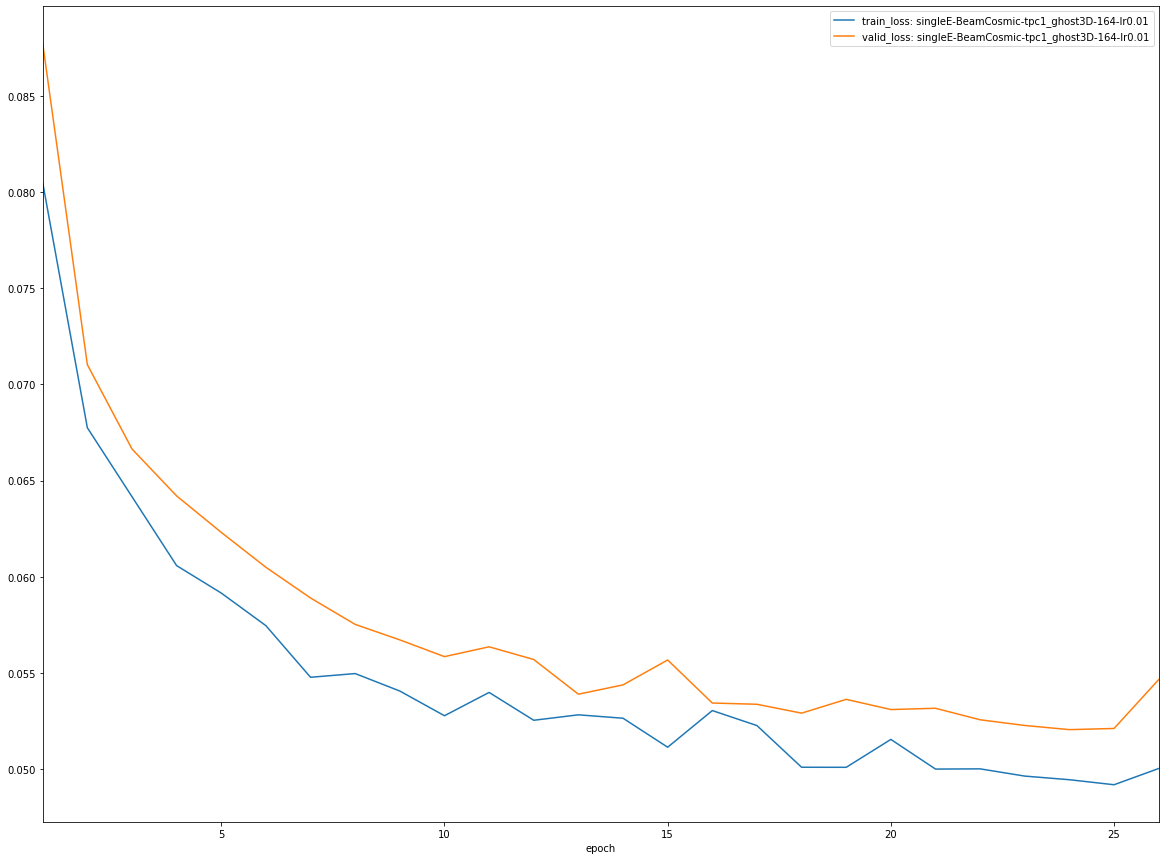

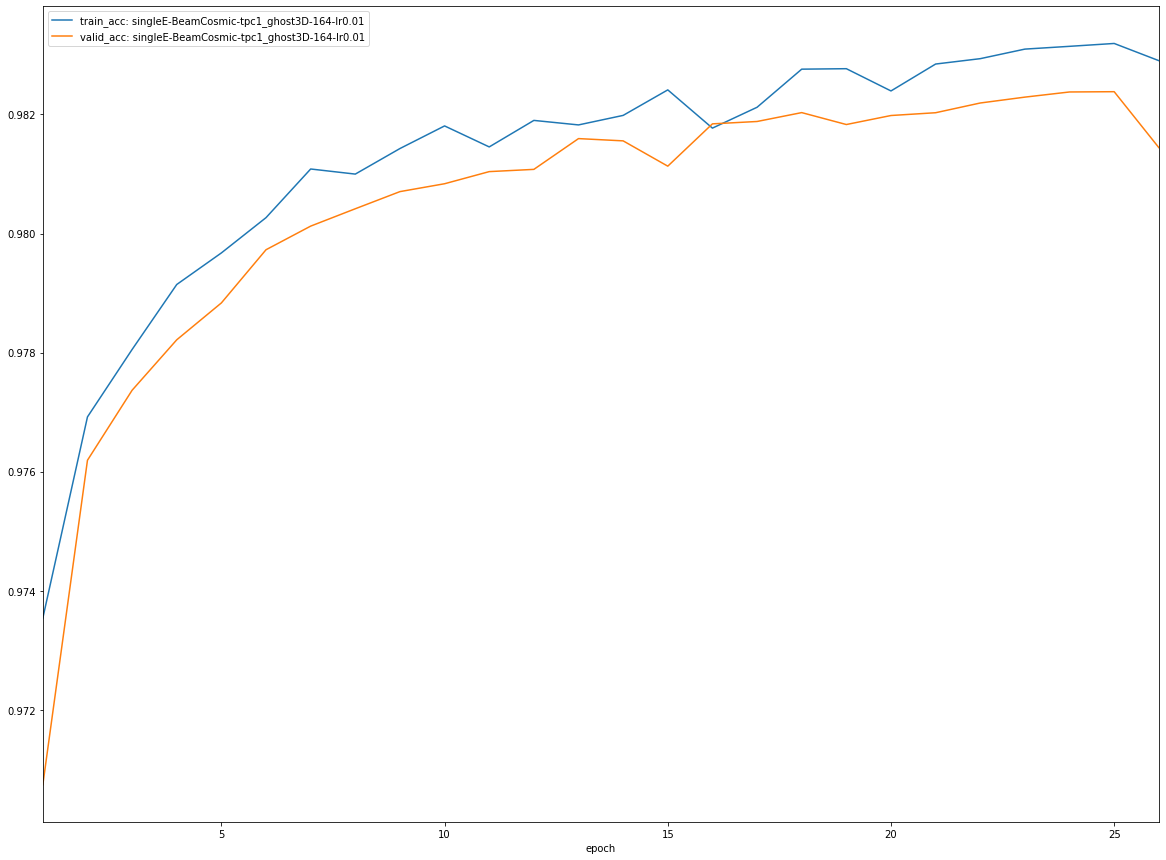

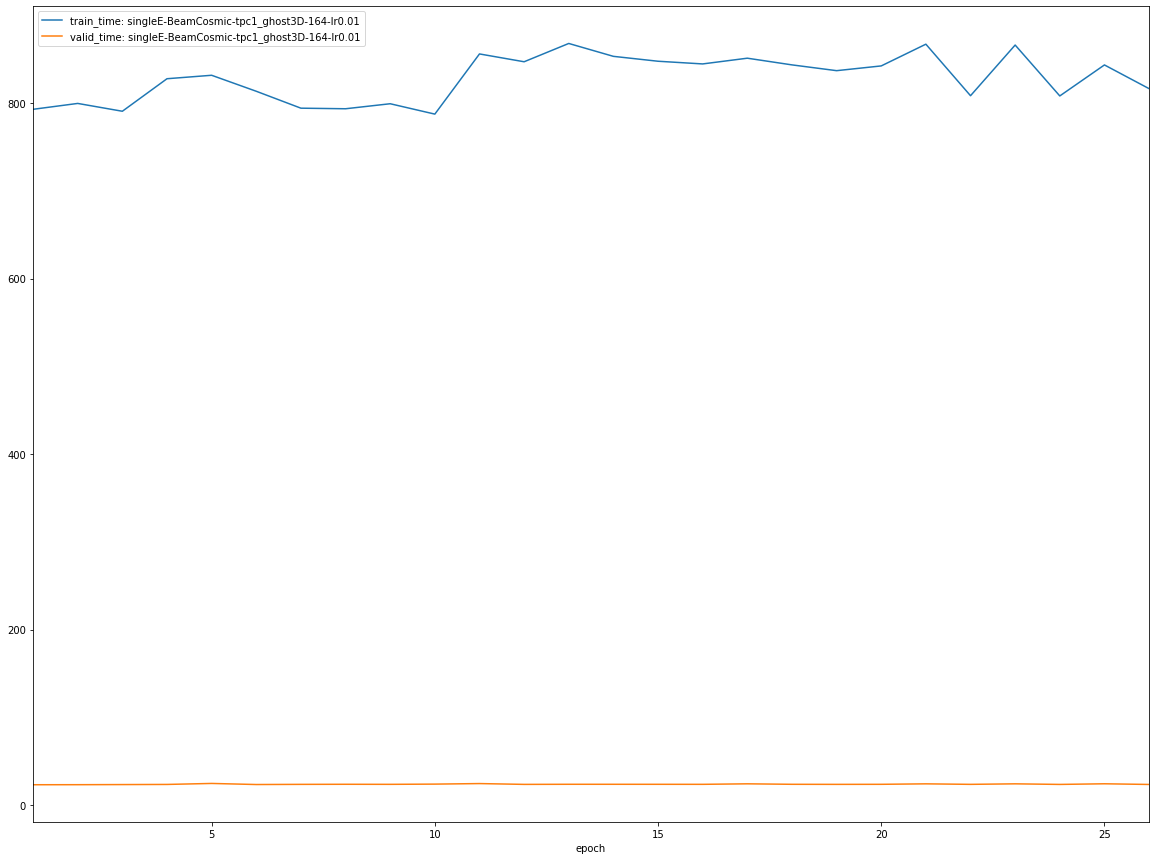

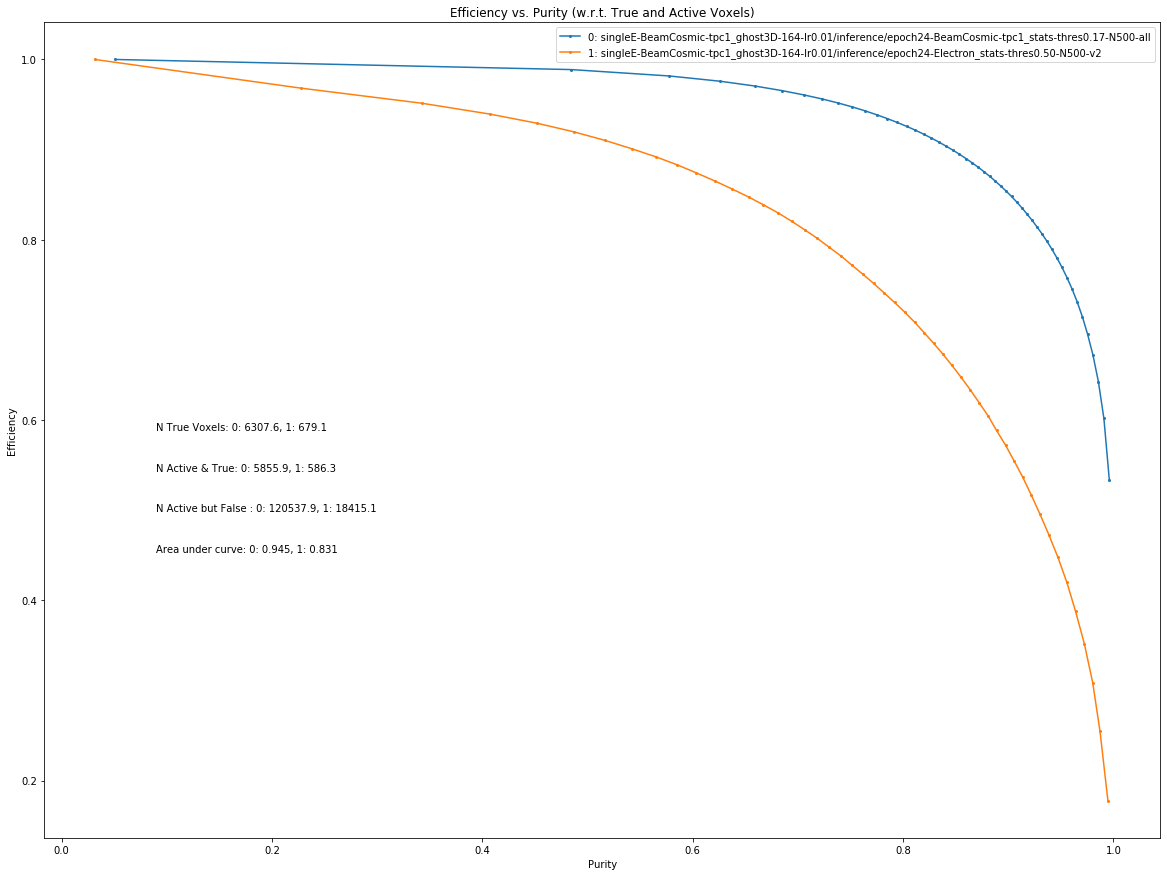

./stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc1_stats-thres0.17-N500-all.npz


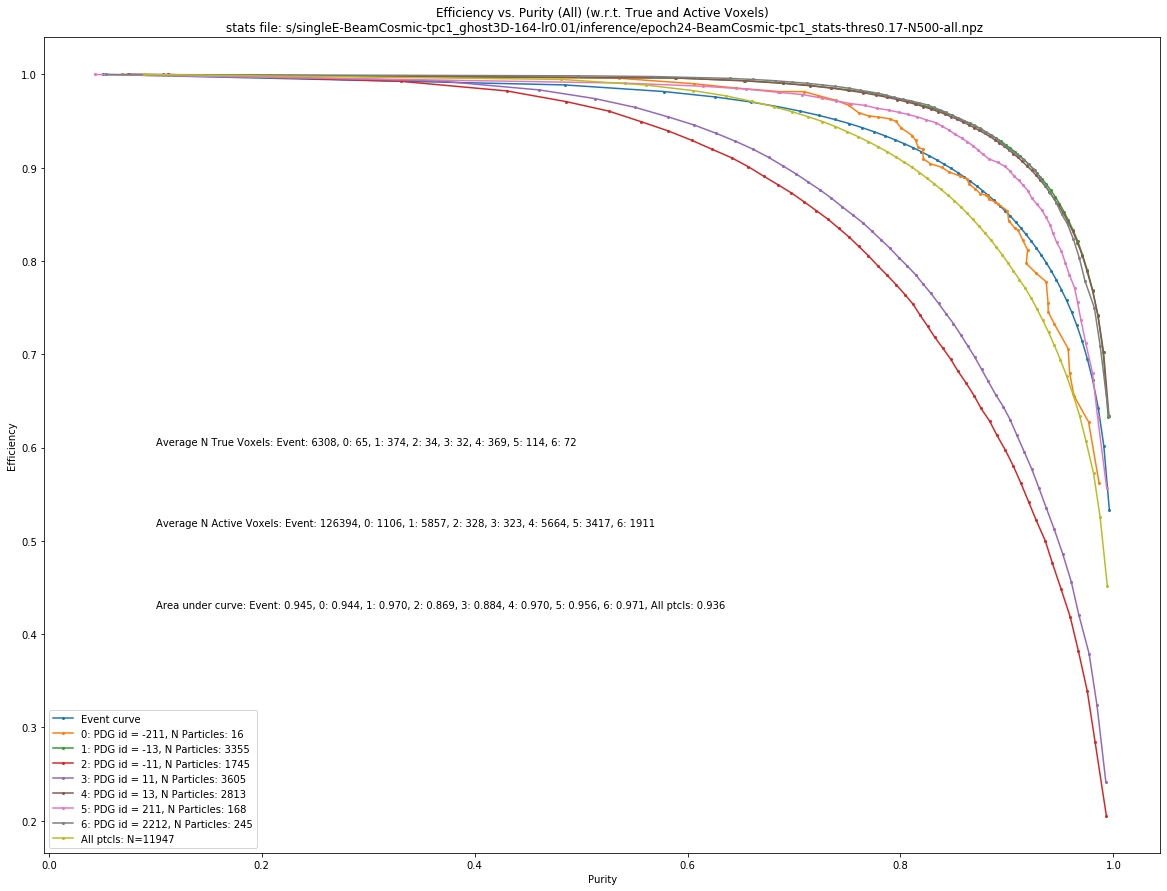

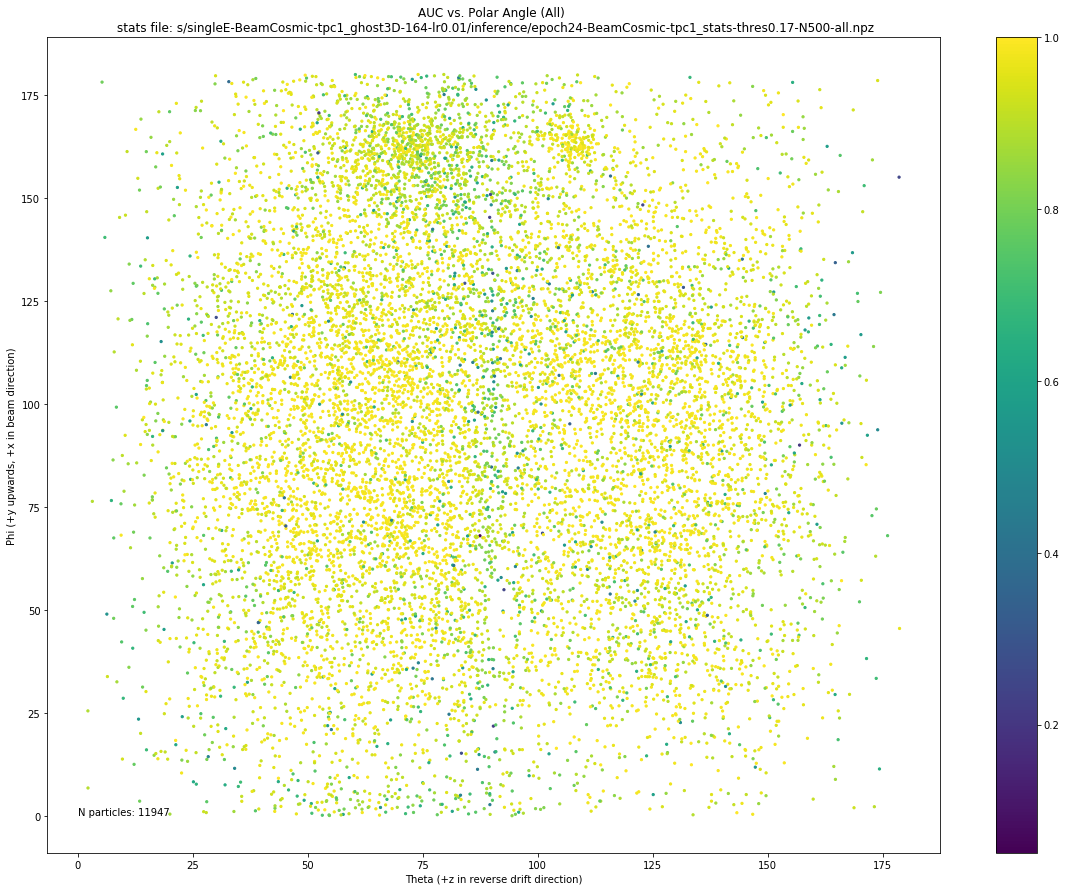

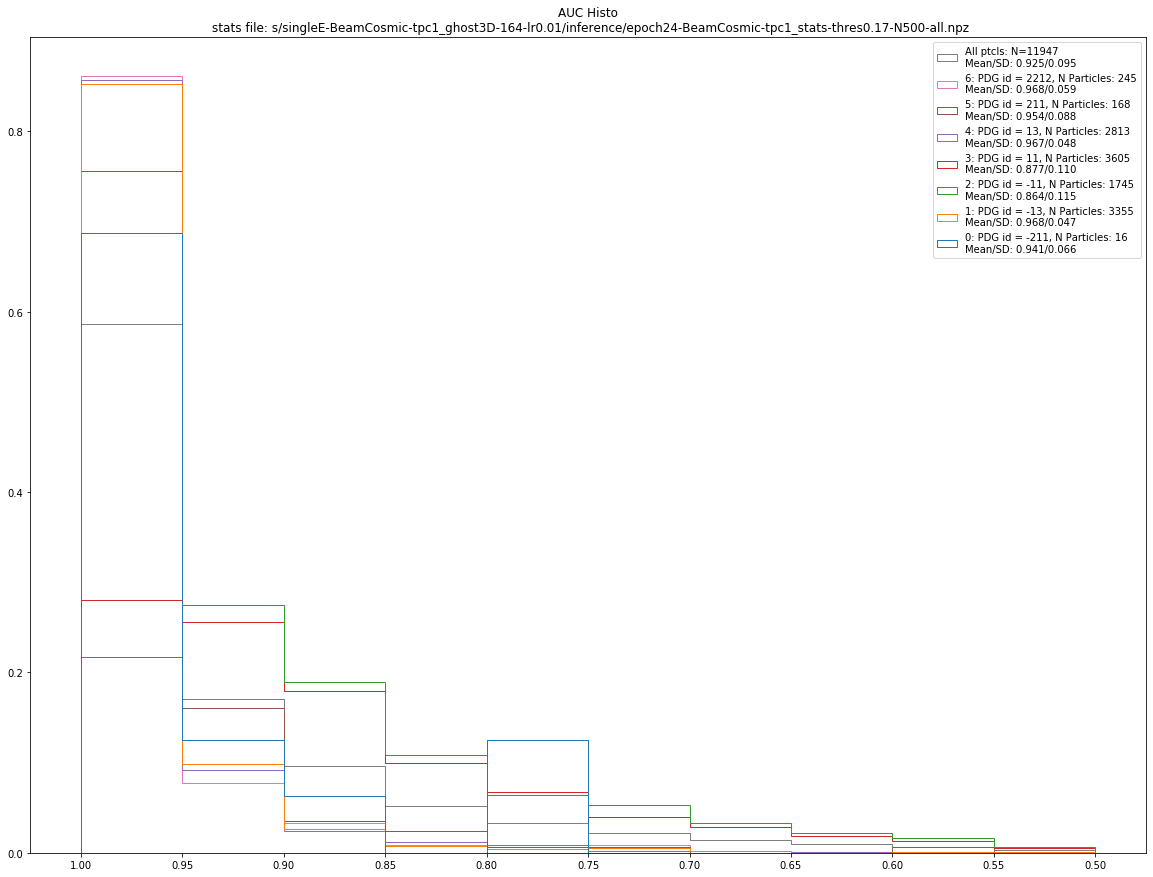

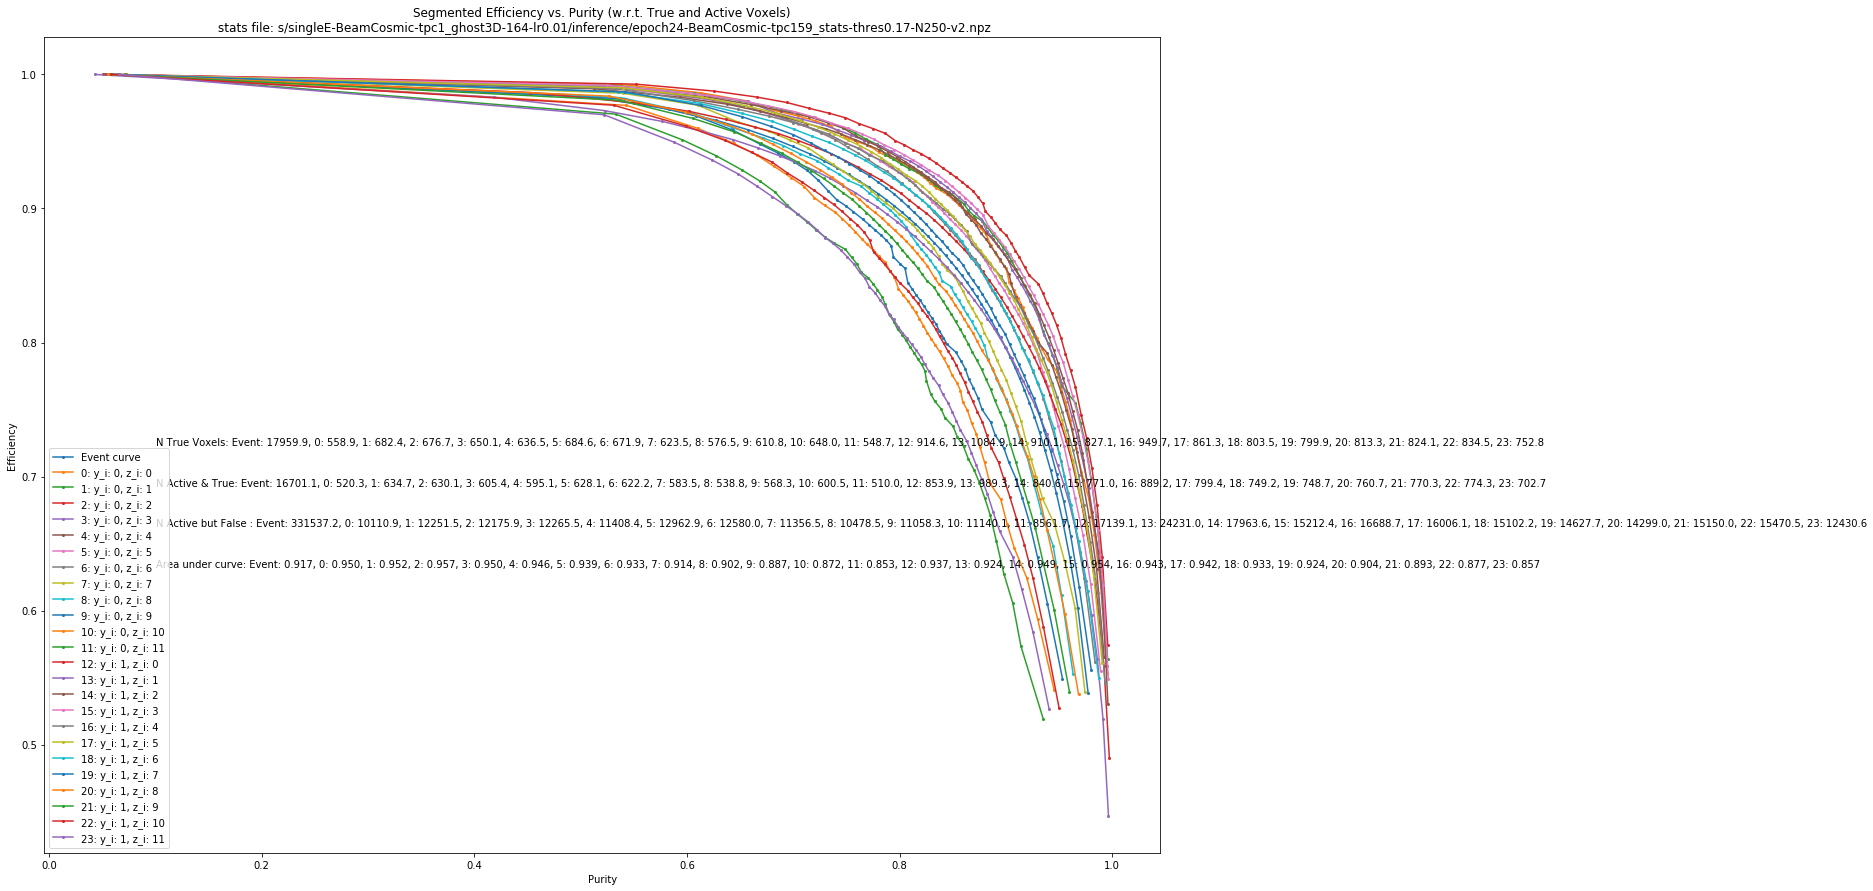

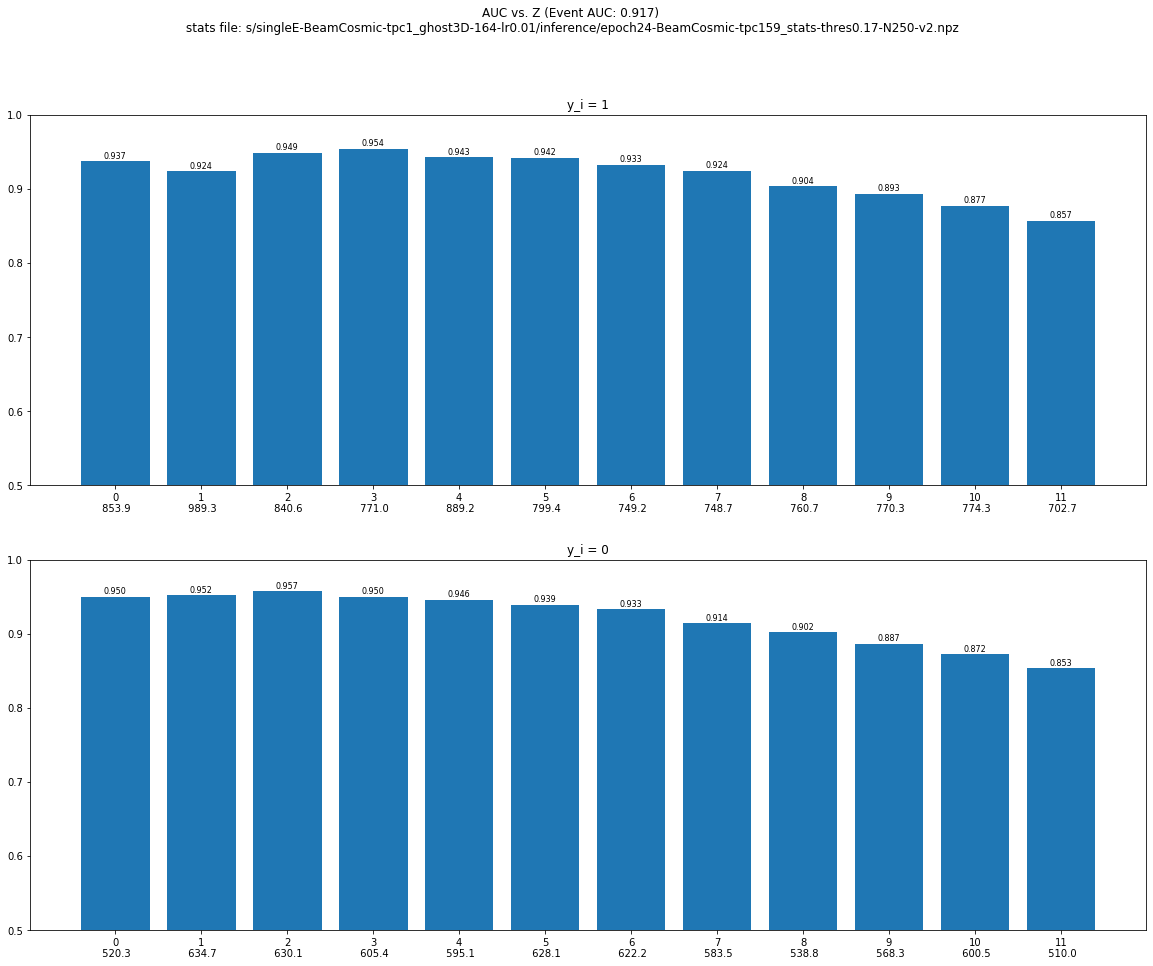

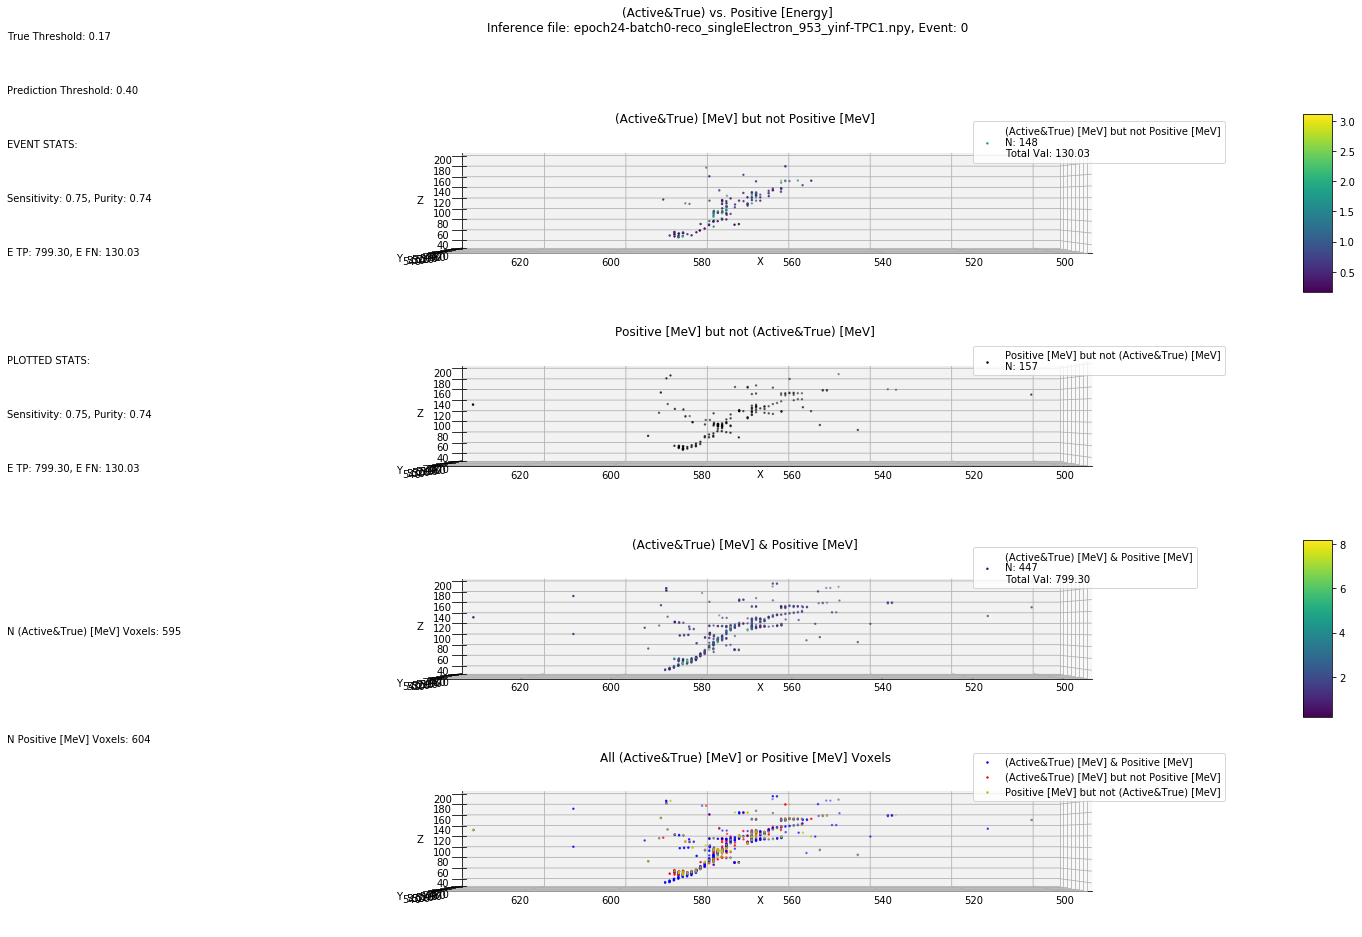

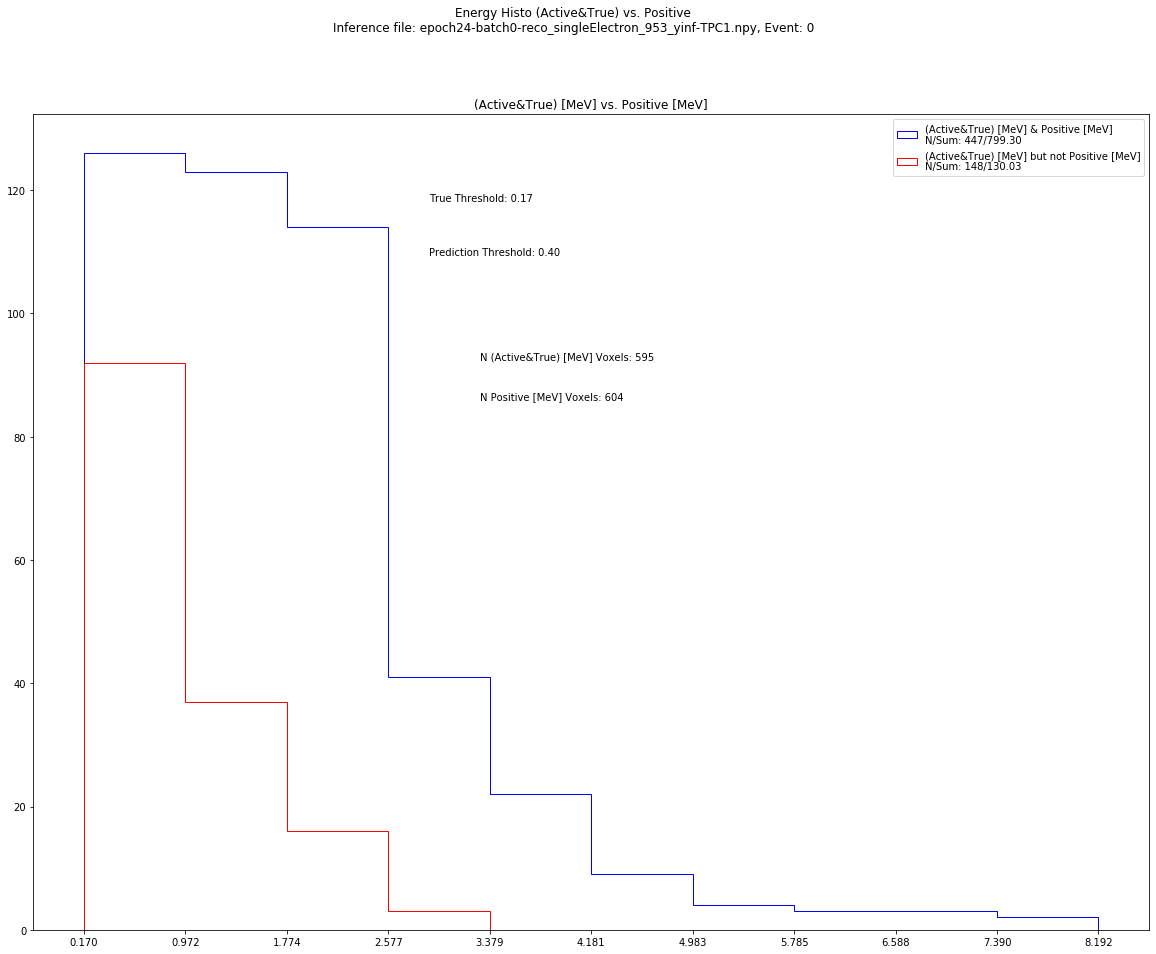

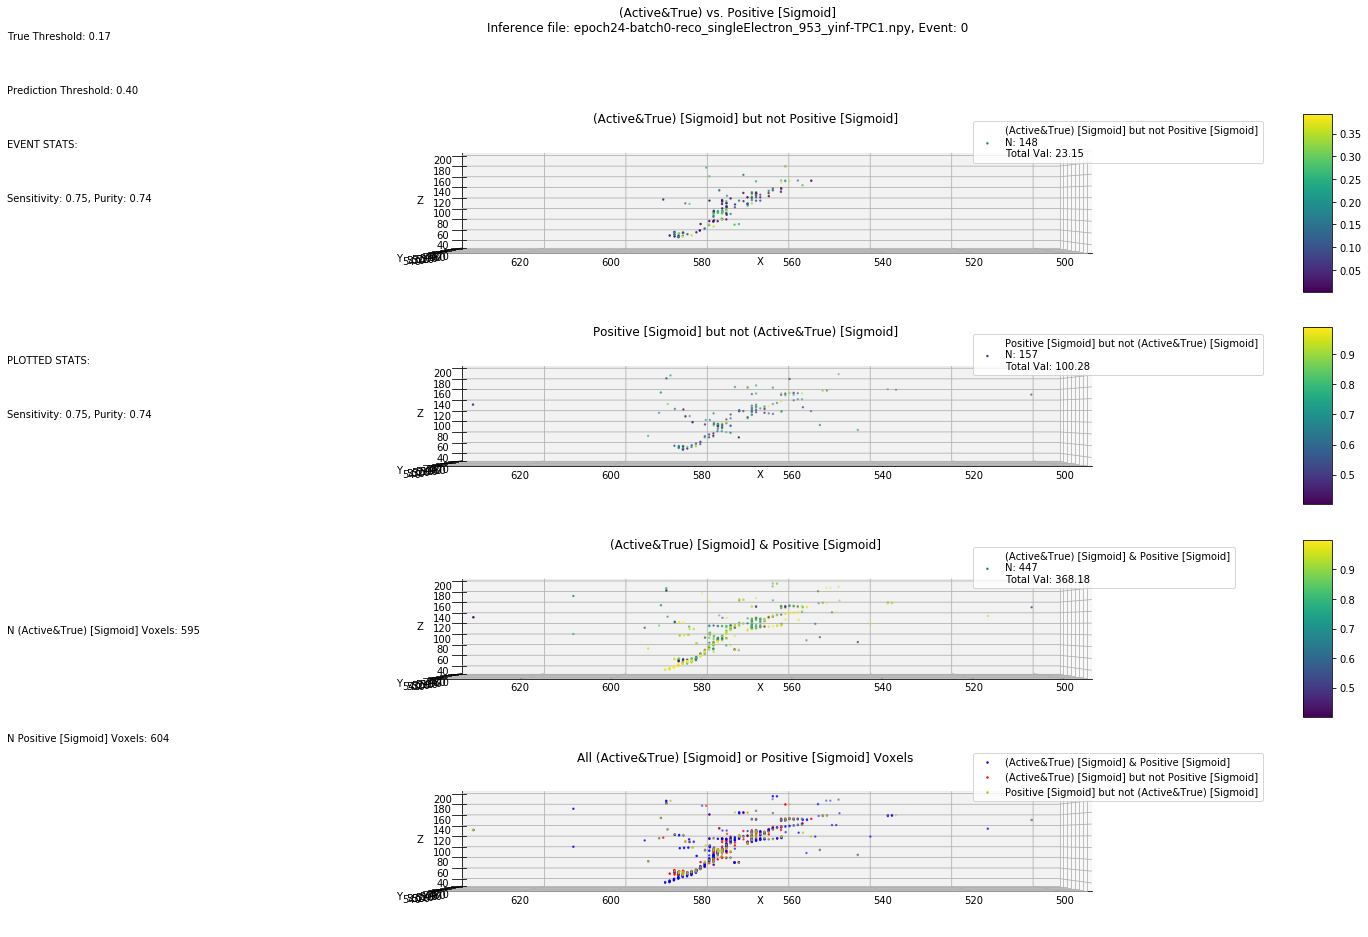

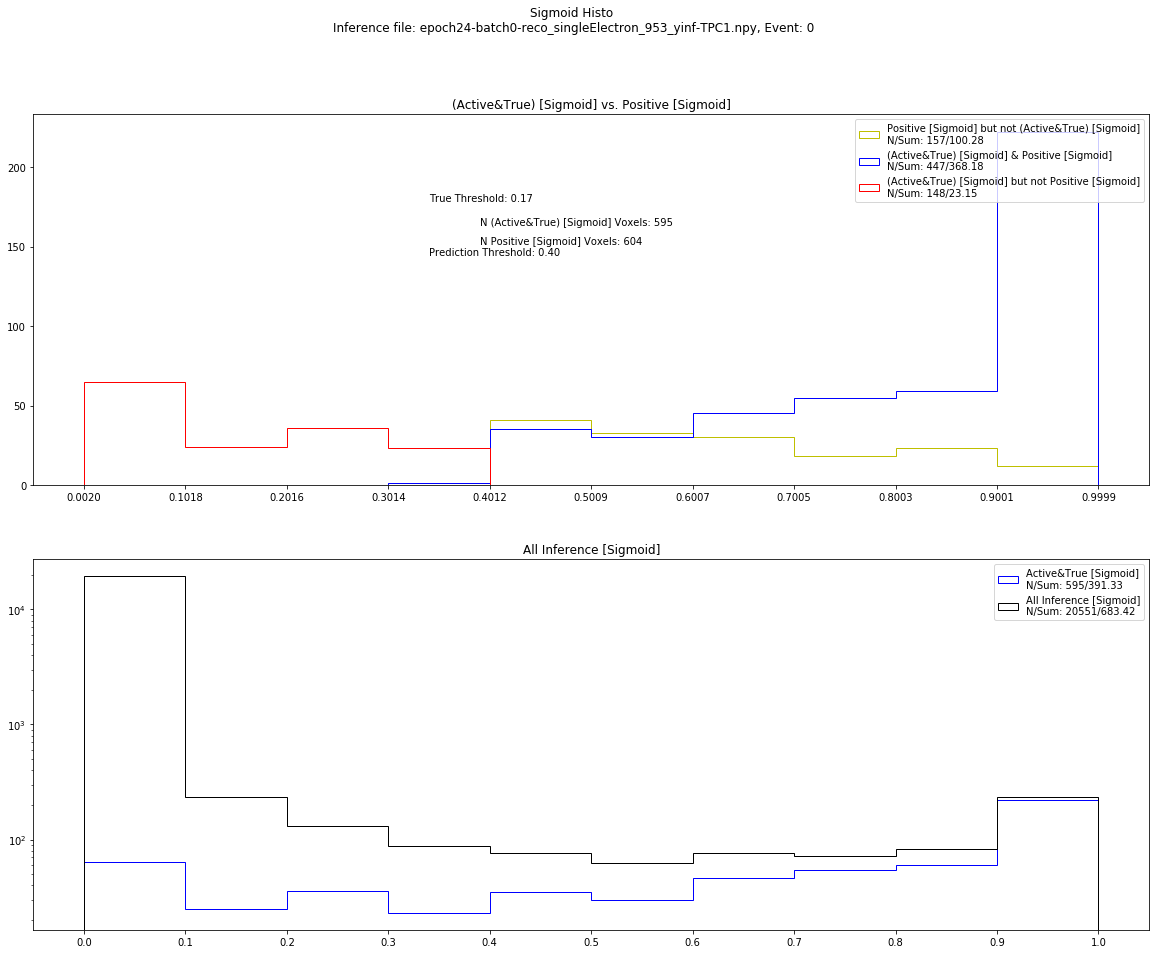

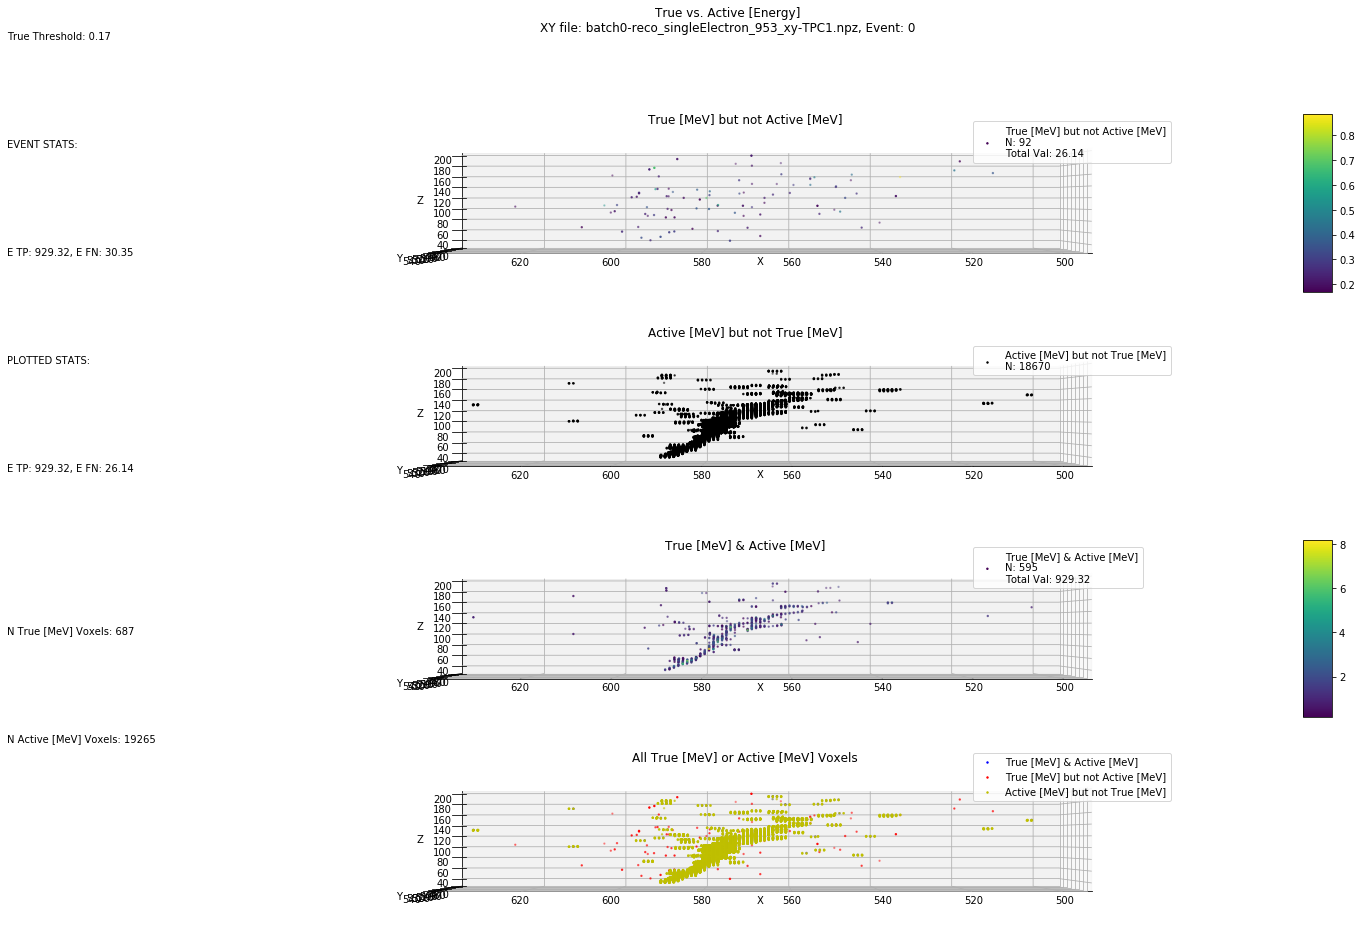

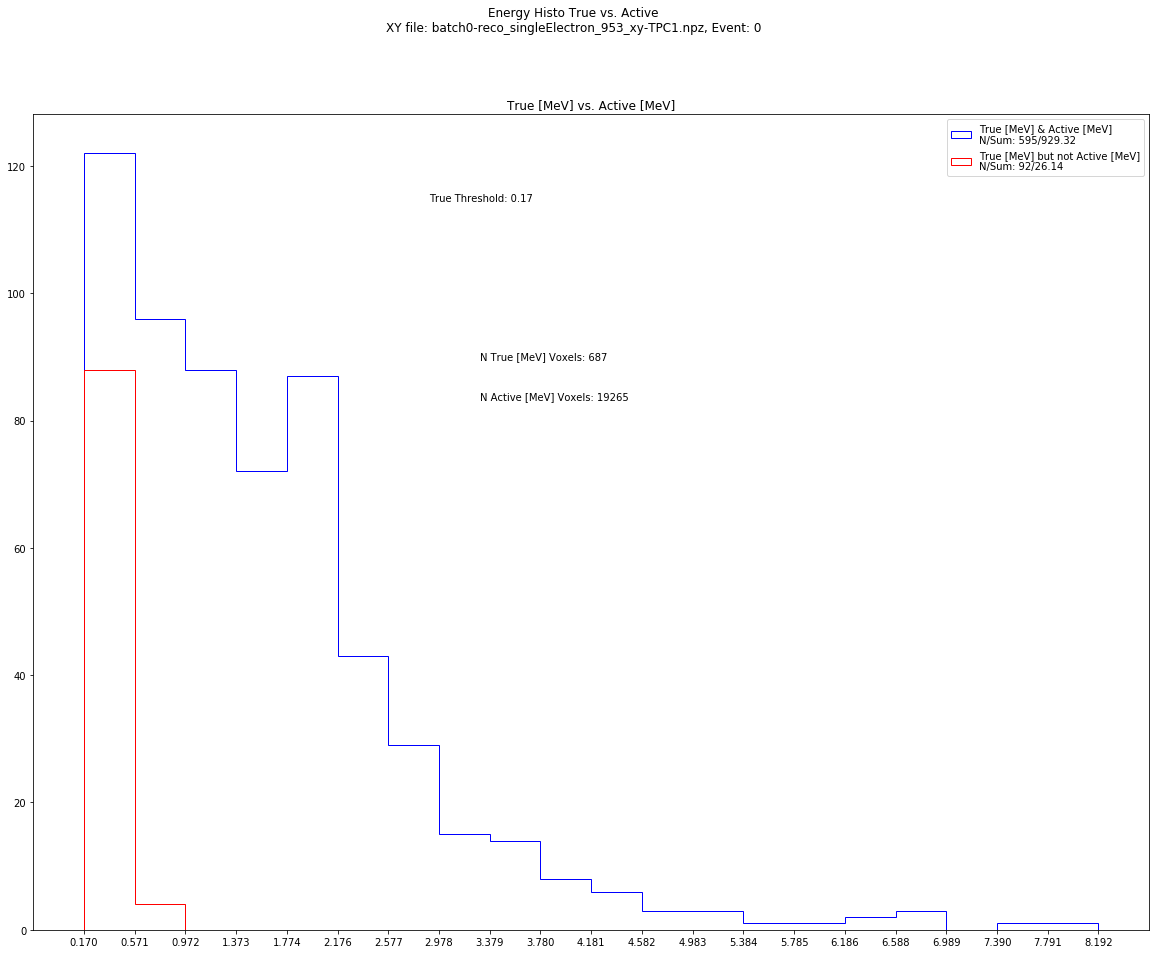

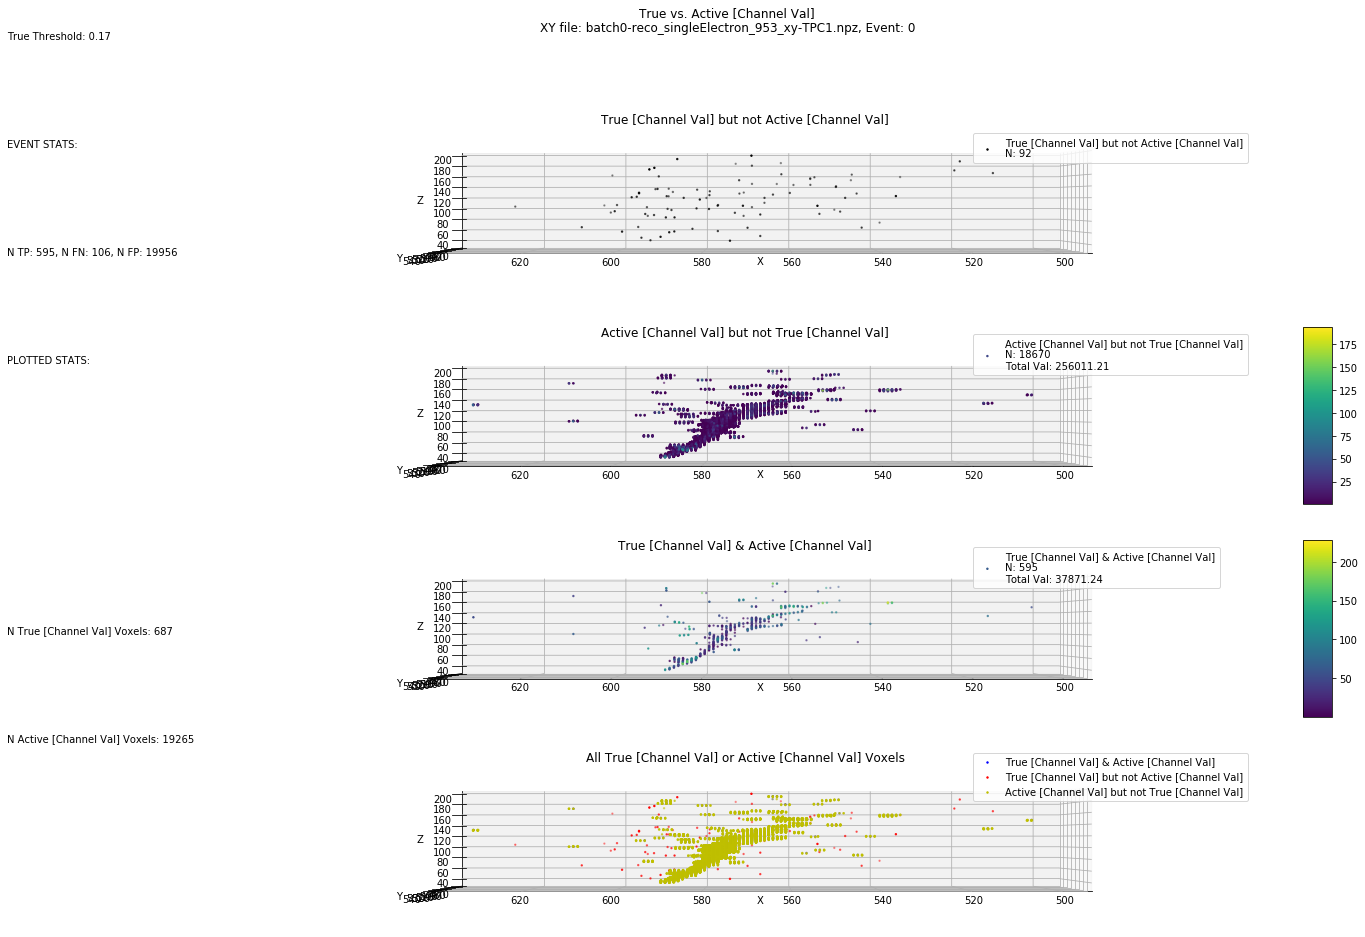

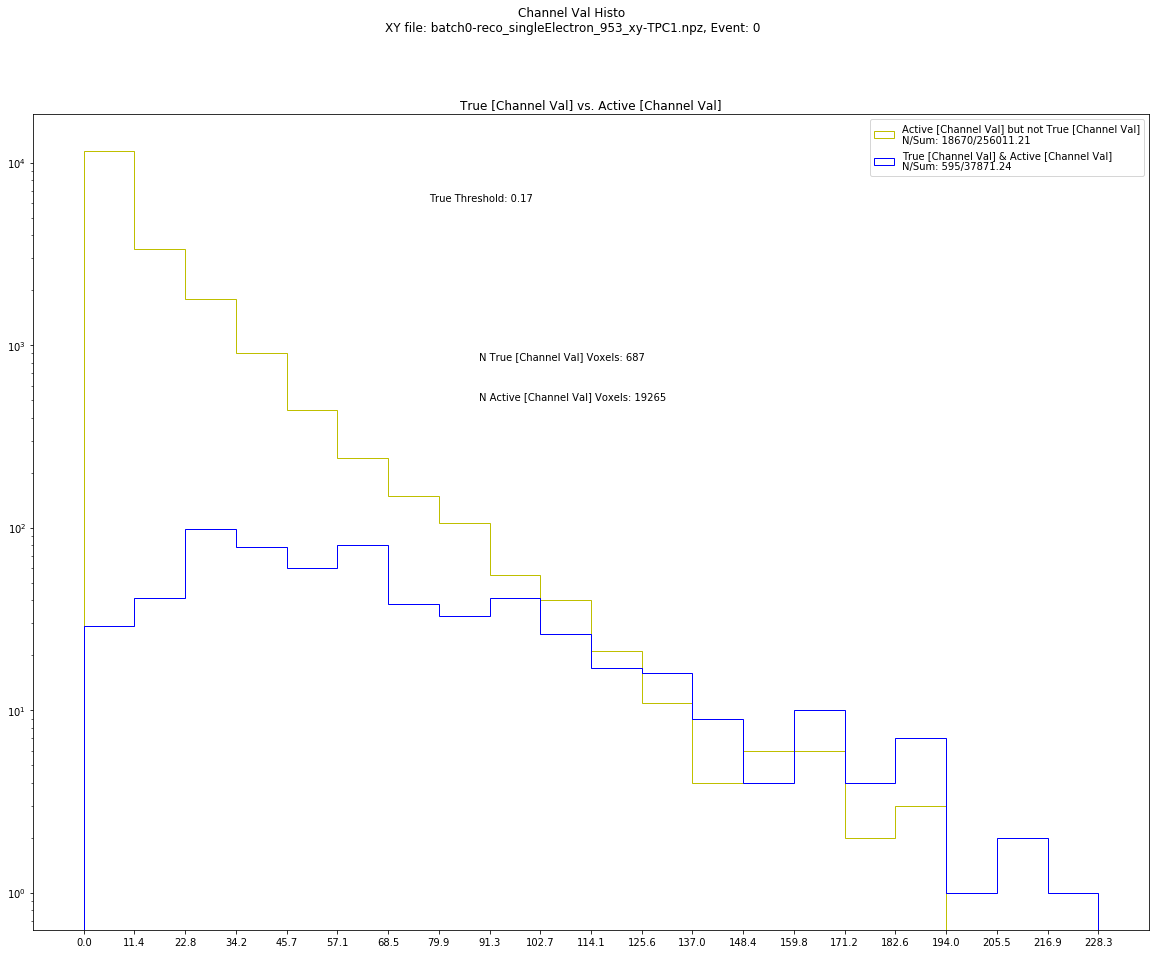

In [5]:
net = 'singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01'
#plot_train_summary(net, 'BeamCosmic-tpc159_ghost3D-164-lr0.01', 'singleElectronWire-v3_3-25k_ghost3D-164-lr0.01', start_epoch=0)
plot_train_summary(net, noderange=(1, 9))
#compute_yinf_stats(net, "reco_1GeV_ElectronWire_xy-v3_3", -2, stride=2, evt_type="Electron", comp_true=True, true_thres=0.5, n_yinf_files=10, inf_dir='inference', event_stats=True, tag="all")
#compute_yinf_stats(net, SIMS[1], -1, stride=1, true_thres=0.17, n_yinf_files=50,  n_events=5, tpc=9)
#compute_yinf_stats(net, "reco_1GeV_BeamCosmic_xy", -2, stride=2, true_thres=0.17, n_yinf_files=50,  n_events=5, segmented=False, event_stats=True, evt_type="BeamCosmic", tpc=1, comp_true=False, inf_dir="round_-1",)
#compute_yinf_stats(net, "reco_1GeV_ElectronWire_xy-v3_3", -2, stride=2, true_thres=0.5, n_yinf_files=10,  n_events=50, segmented=False, event_stats=True, evt_type="Electron", tpc=1, comp_true=False, inf_dir="round_-1",)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "noise_0-1"), select_stats(net, "noise_0-10"), select_stats(net, "noise_10-0"), select_stats(net, "pdspchnoiseAug2018"), select_stats(net, "round_-1"), select_stats(net, "round_0"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
#plot_yinf_stats(select_stats(net, "inference", None, -2, -2))
plot_yinf_stats(["./stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc1_stats-thres0.17-N500-all.npz", 
                 "./stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-Electron_stats-thres0.50-N500-v2.npz"])

#plot_yinf_stats(select_stats('BeamCosmic-tpc159_ghost3D-164-lr0.01', "inference", 0.17, 3, 5))
plot_mc_stats('./stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc1_stats-thres0.17-N500-all.npz')
yinf.plot_segmented_stats(plt.figure(), plt.figure(), './stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc159_stats-thres0.17-N250-v2.npz')

out = widgets.Output()
callback = PlotYinfWidget(out, epoch=-2, tpc=1, evt_type="Electron", file_i=2, net_dir=net, xy_dir='reco_1GeV_ElectronWire_xy-v3_3', true_thres=0.17, view_angle=(0,90), inf_dir='inference')
bnext, bprev, bset, breset, xmin, xmax, ymin, ymax, zmin, zmax, thres, elev, azim, slic, slic_invert, plots = callback.get_widgets()
bs = widgets.HBox([bprev, bnext, bset, breset])
plots_inf = widgets.HBox(plots[:4])
plots_active = widgets.HBox(plots[4:])
viewangle = widgets.HBox([elev, azim, slic_invert])
x_lims = widgets.HBox([xmin, xmax, slic])
y_lims = widgets.HBox([ymin, ymax])
z_lims = widgets.HBox([zmin, zmax])
widgets.VBox([bs, plots_inf, plots_active, thres, viewangle, x_lims, y_lims, z_lims, out])


In [ ]:
net = 'singleE-BeamCosmic-depoElec-tpc1_charge-164-lr0.01'
plot_train_summary(net, start_epoch=25, noderange=(1, 9))

In [ ]:
net = 'singleElectronWire-30k_ghost3D-164-lr0.01'
#plot_train_summary(net,'singleElectronWire-30k_ghost3D-164', start_epoch=5)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
compute_yinf_stats(net, SIMS[1], -1, T_weighted=True, stride=1, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

plot_yinf_stats(select_stats(net, "inference", first=-1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", first=-2, last=-2),  select_stats(net, "inf_piwire"), select_stats(net, "inf_muhit"))

In [ ]:
net = 'singleElectronWire-90k_ghost3D-164-lr0.01'
plot_train_summary('singleElectronWire-30k_ghost3D-164-lr0.01', 'singleElectronWire-30k_ghost3D-164', net, start_epoch=5)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
#compute_yinf_stats(net, SIMS[2], 2, T_weighted=False, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inference", first=3), select_stats('singleElectronWire-30k_ghost3D-164-lr0.01', "inference", first=-2, last=-2))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", first=-10, last=-2),  select_stats(net, "inf_piwire"), select_stats(net, "inf_muhit"))


In [ ]:
net = 'singleElectronWire-90k_ghost3D-164-lr0.01_schedule'
plot_train_summary('singleElectronWire-90k_ghost3D-164-lr0.01', net, start_epoch=2)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
compute_yinf_stats(net, SIMS[2], 2, T_weighted=False, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

plot_yinf_stats(select_stats(net, "inference", first=3), select_stats('singleElectronWire-30k_ghost3D-164-lr0.01', "inference", first=-2, last=-2))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", first=-10, last=-2),  select_stats(net, "inf_piwire"), select_stats(net, "inf_muhit"))

In [ ]:
net = 'singleElectronWire-30k-thres0.5_ghost3D-164-lr0.01'
plot_train_summary(net,'singleElectronWire-30k_ghost3D-164-lr0.01', start_epoch=5)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
compute_yinf_stats(net, SIMS[1], 5, T_weighted=False, stride=1, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

plot_yinf_stats(select_stats(net, "inference",))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", first=-1),  select_stats(net, "inf_piwire"), select_stats(net, "inf_muhit"))


In [ ]:
net = 'singleElectronWire-20k-thres0.5_ghost3D-164'
plot_train_summary(net,'singleElectronWire-30k_ghost3D-164-lr0.01', start_epoch=5)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
compute_yinf_stats(net, SIMS[1], 6, T_weighted=False, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

plot_yinf_stats(select_stats(net, "inference",), select_stats('singleElectronWire-30k_ghost3D-164-lr0.01', "inference", first=-2, last=-2))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", first=-1),  select_stats(net, "inf_piwire"), select_stats(net, "inf_muhit"))


In [ ]:
net = 'singleElectronWire-30k_ghost3D-324-lr0.01'
plot_train_summary(net,'singleElectronWire-30k_ghost3D-164-lr0.01', start_epoch=5)
#compute_yinf_stats(net, SIMS[6], true_thres=0.5, n_yinf_files=5, inf_dir='inf_piwire')
compute_yinf_stats(net, SIMS[1], -1, stride=1, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", 0.5, -1),  select_stats(net, "inference", 3, -1), select_stats(net, "inf_piwire"), 
                select_stats(net, "inf_muhit"))


In [ ]:
net = 'singleElectronWire-30k_ghost3D-164-lr0.1'
plot_train_summary(net,'singleElectronWire-30k_ghost3D-164', start_epoch=5)
#compute_yinf_stats(net, SIMS[4], true_thres=0.5, n_yinf_files=5, inf_dir='inf_muhit')
compute_yinf_stats(net, SIMS[1], 5, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1), select_stats('singleElectronWire-30k_ghost3D-164', 'inference',0.5, 5, 10),)
plot_yinf_stats(select_stats(net, "inference", 0.5, -1), select_stats(net, "inf_train"), select_stats(net, "inf_muhit"))

In [ ]:
net = 'singleElectronWire_ghost3D-164_L10'
plot_train_summary(net, 10)
#compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')
compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2), select_stats(net, "inf_train"))

In [ ]:
net = 'singleElectronWire_ghost3D-164_L1-3'
plot_train_summary(net, 20)
#compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')
compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[1], 1, stride=2, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
plot_yinf_stats(select_stats(net, "inference", 0.5, -6, stride = 1))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2), select_stats(net, "inf_train"))

In [ ]:
THRES=0.5

plot_yinf_stats(select_stats('sparse_singleElectronHit_ghost3D', 'inference', first=-1), 
               select_stats('singleElectronHit_ghost2D_1652-rep4_L1-2', 'inference', THRES, first= -1),
                select_stats('singleElectronHit_ghost2D_1652-rep4', 'inference', THRES,first= -1),
               select_stats('sparse_singleElectronHit_ghost2D_1652', 'inference', THRES, first= -1),
               select_stats('singleElectronHit_ghost3D-164', 'inference', THRES, -1),
                select_stats('singleElectronHit_ghost3D-164_L1-1', 'inference', THRES, first= -1),
               select_stats('singleElectronHit_ghost3D-164_L1-3', 'inference', THRES, first= -1),
                select_stats('singleElectronWire_ghost3D-164', 'inference', THRES, -1),)
                #['./stats//sparse_singleElectronHit_ghost2D_1652/inference/epoch27_stats-N250.npz',
                    #'./stats//singleElectronHit_ghost2D_1652-rep4/inference/epoch20_stats-N250.npz', 
                   #'./stats//singleElectronHit_ghost3D-164/inference/epoch18_stats-N250.npz',])
            
plot_yinf_stats(
               select_stats('singleElectronHit_ghost2D_1652-rep4_L1-2', 'inference', THRES, first= -1),
                select_stats('singleElectronHit_ghost2D_1652-rep4', 'inference', THRES,first= -1),
               select_stats('sparse_singleElectronHit_ghost2D_1652', 'inference', THRES, first= -1),)

plot_yinf_stats(select_stats('sparse_singleElectronHit_ghost3D', 'inference', first=-1), 
    select_stats('singleElectronHit_ghost3D-164', 'inference', THRES, -1),
                select_stats('singleElectronHit_ghost3D-164_L1-1', 'inference', THRES, first= -1),
               select_stats('singleElectronHit_ghost3D-164_L1-3', 'inference', THRES, first= -1),
                select_stats('singleElectronWire_ghost3D-164', 'inference', THRES, -1),
               select_stats('singleElectronWire_ghost3D-164_L1-3', 'inference', THRES, -1),)
            
plot_yinf_stats(select_stats('singleElectronHit_ghost3D-164', 'inference', THRES, -1),
               select_stats('singleElectronHit_ghost3D-164', 'inf_train',  THRES, first=-1),
               select_stats('singleElectronHit_ghost2D_1652-rep4', 'inference', THRES, -1),
               select_stats('singleElectronHit_ghost2D_1652-rep4', 'inf_train',  THRES, first=-1),
                select_stats('singleElectronHit_ghost2D_1652-rep4_L1-2', 'inference', THRES, -1),
                select_stats('singleElectronHit_ghost2D_1652-rep4_L1-2', 'inf_train',  THRES, first= -1),
                select_stats('sparse_singleElectronHit_ghost2D_1652', 'inference', first= -1),
                select_stats('singleElectronHit_ghost3D-164_L1-1', 'inference', THRES, first= -1)
            )


In [ ]:
THRES=0.5
plot_yinf_stats(
                select_stats('singleElectronWire-30k_ghost3D-164-lr0.01', 'inference', THRES, -2, -2),  
    select_stats('singleElectronWire-v2_ghost3D-164-lr0.01', 'inference', THRES, -1),    
    select_stats('singleElectronWire-90k_ghost3D-164-lr0.01', 'inference', THRES, -1, -1),    
    select_stats('singleElectronWire-50k-v2_ghost3D-164-lr0.01', 'inference', THRES, -1), 
    select_stats('singleElectronWire_ghost3D-164_LabelWeightedCE-10', 'inference', THRES, -1), 
    select_stats('singleElectronWire-v3_3-25k_ghost3D-164_LabelWeightedCE-10-lr0.01', 'inference', THRES, -1), 
    select_stats('singleElectronWire-v3_3-25k_ghost3D-164-lr0.01', 'inference', THRES, -1), 
    
               )
plot_train_summary('singleElectronWire-30k_ghost3D-164','singleElectronWire-30k_ghost3D-164-lr0.01',
                   'singleElectronWire-v2_ghost3D-164-lr0.01', 'singleElectronWire-50k-v2_ghost3D-164-lr0.01_schedule', start_epoch=2)

In [ ]:
net = 'sparse_singleMuHit_ghost3D'
#plot_train_summary(net, 5)
#compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2), select_stats(net, "inf_train"))

out = widgets.Output()
callback = PlotYinfWidget(out, net_dir=net, xy_dir=SIMS[4], true_thres=0, view_angle=(0,90), inf_dir='inference')
bnext, bprev, bset, breset, xmin, xmax, ymin, ymax, zmin, zmax, thres, elev, azim, slic, slic_invert, plots = callback.get_widgets()
bs = widgets.HBox([bprev, bnext, bset, breset])
plots_inf = widgets.HBox(plots[:4])
plots_active = widgets.HBox(plots[4:])
viewangle = widgets.HBox([elev, azim, slic_invert])
x_lims = widgets.HBox([xmin, xmax, slic])
y_lims = widgets.HBox([ymin, ymax])
z_lims = widgets.HBox([zmin, zmax])
widgets.VBox([bs, plots_inf, plots_active, thres, viewangle, x_lims, y_lims, z_lims, out])

In [ ]:
net = 'sparse_singleMu'
#plot_train_summary(net, 5)
#compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2), select_stats(net, "inf_train"))

out = widgets.Output()
callback = PlotYinfWidget(out, net_dir=net, xy_dir=SIMS[10], true_thres=0, view_angle=(0,90), inf_dir='eval_out')
bnext, bprev, bset, breset, xmin, xmax, ymin, ymax, zmin, zmax, thres, elev, azim, slic, plots = callback.get_widgets()
bs = widgets.HBox([bprev, bnext, bset, breset])
plots_inf = widgets.HBox(plots[:4])
plots_active = widgets.HBox(plots[4:])
viewangle = widgets.HBox([elev, azim])
x_lims = widgets.HBox([xmin, xmax, slic])
y_lims = widgets.HBox([ymin, ymax])
z_lims = widgets.HBox([zmin, zmax])
widgets.VBox([bs, plots_inf, plots_active, thres, viewangle, x_lims, y_lims, z_lims, out])

In [ ]:
net = 'singleElectronWire_sparse3D-164'
plot_train_summary(net, 5)
#compute_yinf_stats(net, SIMS[0], true_thres=0.5, n_yinf_files=5, inf_dir='inf_train')
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0.5, n_yinf_files=5)
#compute_yinf_stats(net, SIMS[0], 1, true_thres=0, n_yinf_files=5)

#plot_yinf_stats(select_stats(net, "inf_train"))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2))
#plot_yinf_stats(select_stats(net, "inference", 0.5, -12, stride = 2), select_stats(net, "inf_train"))

out = widgets.Output()
callback = PlotYinfWidget(out, net_dir=net, xy_dir=SIMS[1], true_thres=0.5, view_angle=(0,90), inf_dir='inference', sigmoid=False)
bnext, bprev, bset, breset, xmin, xmax, ymin, ymax, zmin, zmax, thres, elev, azim, slic, plots = callback.get_widgets()
bs = widgets.HBox([bprev, bnext, bset, breset])
plots_inf = widgets.HBox(plots[:4])
plots_active = widgets.HBox(plots[4:])
viewangle = widgets.HBox([elev, azim])
x_lims = widgets.HBox([xmin, xmax, slic])
y_lims = widgets.HBox([ymin, ymax])
z_lims = widgets.HBox([zmin, zmax])
widgets.VBox([bs, plots_inf, plots_active, thres, viewangle, x_lims, y_lims, z_lims, out])

The following cells are just some miscellaneous analysis

In [ ]:
THRES=0.5
plot_yinf_stats(
                select_stats('sparse_singleMuHit_ghost3D', 'inference),
                select_stats('singleElectronWire-30k_ghost3D-164-lr0.01', 'inf_muhit', THRES, -1),    
                
               )

In [ ]:
def parse_xy(event = 1, E_scale = 1, xy_file = sys.argv[1]):
    with np.load(xy_file, allow_pickle=True) as xy_f:
        pix_batch=xy_f["X"]
        energys_batch = xy_f["Y"]
        energys_truth = xy_f["Y_truth"]
        event_starts=xy_f["starts"]
    event_starti = event_starts[event]
    if event == len(event_starts)-1:
        event_endi = -1
        event_pixels = pix_batch[event_starti:]
        event_energys = energys_batch[event_starti:]
    else:
        event_endi = event_starts[event+1]
        event_pixels = pix_batch[event_starti:event_endi]
        event_energys = energys_batch[event_starti:event_endi]
    coords_active = event_pixels[:,:3]
    voxel_active = {tuple(pt[:3]):sum(pt[4:]) for pt in event_pixels}
    event_truth = energys_truth[event]
    #voxel_truth = {tuple(pt[:3]):pt[3]*E_scale for pt in event_truth}
    voxel_truth={tuple(coord): energy for coord, energy in zip (coords_active, event_energys)}
    return voxel_truth, voxel_active, (event_starti, event_endi, coords_active)

In [ ]:
voxel_truth, voxel_active, (event_starti, event_endi, coords_active) = products.parse_xy(15, 1,
                                                                                            SIM_DIR+SIMS[1]+'/batch1-reco_singleElectron_701_xy-TPC1.npz')
voxel_truth2, voxel_active, (event_starti, event_endi, coords_active) = parse_xy(15, 1,
                                                                                            SIM_DIR+SIMS[1]+'/batch1-reco_singleElectron_701_xy-TPC1.npz')



In [ ]:

for k, v in voxel_truth.items():
    if k not in voxel_truth2:
        continue
    if voxel_truth2[k] != v:
        print("false")
    else:
        continue
        print("correcr")

In [ ]:
voxel_truth, voxel_active2, event_info = products.parse_xy(24, 1,
                            SIM_DIR+SIMS[1]+'/batch0-reco_singleElectron_701_xy-TPC1.npz')
voxel_yinf = yinf.parse_yinf(event_info, ML_DIR+'singleElectronWire-downsample(4,2,2)_ghost2D-3251/inf_train/epoch6-batch0-reco_singleElectron_701_yinf-TPC1.npy')

In [ ]:

yinf_l=np.array(list(voxel_yinf.values()))
truth=np.array([1 if coord in voxel_truth else 0 for coord in voxel_yinf.keys()])


yinf_l=np.load( ML_DIR+'singleElectronWire-downsample(4,2,2)_ghost2D-3251/inf_train/epoch6-batch0-reco_singleElectron_745_yinf-TPC1.npy').squeeze()
truth=np.load(SIM_DIR+SIMS[1]+'/batch0-reco_singleElectron_745_xy-TPC1.npz')['Y']
print(truth.shape)

truth=np.where(truth>0, 1, 0).squeeze()
yinf_1=np.where(yinf_l>0.5, 1, 0)

print(sum(yinf_1==truth)/len(yinf_l))



In [ ]:
yinf_l=np.load(ML_DIR+'singleElectronWire-90k_ghost3D-164-lr0.01/inference/epoch32-batch0-reco_singleElectron_911_yinf-TPC1.npy').squeeze()
truth=np.load(SIM_DIR+SIMS[2]+'/batch0-reco_singleElectron_911_xy-TPC1.npz')['X']
truth2=np.load(SIM_DIR+SIMS[2]+'/batch0-reco_singleElectron_911_xy-TPC1.npz')['Y']
print(truth.shape)
print(truth2.shape)
truth=np.where(truth>0, 1, 0).squeeze()
yinf_1=np.where(yinf_l>0.5, 1, 0)
print(yinf_1.shape)
print(truth.shape)
print(sum(yinf_1==truth)/len(yinf_l))

In [ ]:
def parse_pixel(event, E_scale, xy_file):
    with np.load(xy_file, allow_pickle=True) as xy_f:
        pix_batch=xy_f["pix"]
        event_starts=xy_f["starts"]
    event_starti = int(event_starts[event])
    if event == len(event_starts)-1:
        event_endi = -1
        event_pixels = pix_batch[event_starti:]
    else:
        event_endi = int(event_starts[event+1])
        event_pixels = pix_batch[event_starti:event_endi]
    coords_active = event_pixels[:,:3]
    voxel_active = {tuple(pt[:3]):pt[5] for pt in event_pixels}
    return voxel_active

voxel_pixel=parse_pixel(1, 1, SIM_DIR+'reco_1GeV_Electron_parsed'+'/batch0-reco_singleElectron_701_pixel-TPC1.npz')
print((1006*4, 915.0*2, 300*2) in voxel_pixel)

In [ ]:
print((1126.0*4, 990.0*4, 387.0*2) in voxel_pixel)
#util.filter_voxels_coord(((1006*4, 1007*4), (300*2, 301*2), (915.0*2, 916*2)), voxel_pixel)
slic = util.downsample_voxels((-1, 1, 1,), *util.filter_voxels_coord(((4560, 4561), (400,500), (1800,2100)), voxel_pixel))[0]
fig=plt.figure()
ax=fig.add_subplot()
util.scatter_voxel(fig, ax, slic, is2d=True)

In [ ]:
print((1126.0*4, 990.0*4, 387.0*2) in voxel_pixel)
#util.filter_voxels_coord(((1006*4, 1007*4), (300*2, 301*2), (915.0*2, 916*2)), voxel_pixel)
slic = util.downsample_voxels((-1, 1, 1,), *util.filter_voxels_coord(((570, 571), None, None), voxel_active2))[0]
fig=plt.figure()
ax=fig.add_subplot()
util.scatter_voxel(fig, ax, slic, is2d=True, view_angle=True)

In [ ]:
comp=util.comp_voxels(voxel_active, voxel_active2)

print(comp[0])

print(comp[3])
print(util.filter_voxels_coord(((328, 333), (1480, 1500), (560, 580)), voxel_active))
util.filter_voxels_coord(((328, 333), (1480, 1500), (560, 580)), voxel_active2)
#(965.0, 1041.0, 450.0) in comp[0]
#[v for k,v in comp[0].items() if k[0]==1006.0]

In [ ]:
comp=util.comp_voxels(voxel_truth, voxel_truth2)
[(k, v) for k, v in comp[1].items() if comp[1][k]!=comp[2][k]]

In [ ]:
util.scatter_voxels_comp(plt.figure(), comp, "from_pix", "direct")

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(projection="3d")
util.scatter_voxel(fig, ax, voxel_truth)

In [ ]:
products.compare_true_active(plt.figure(), None, plt.figure(), None, true_thres=0.5/3, event=1, 
                             xy_file=SIM_DIR+'reco_1GeV_MuHit_xy'+'/batch0-reco_singleMu_016_xy-TPC1.npz',
                             plot_slice=True, plot_lims = ((550,551), None, None), view_angle=None
                            )

In [ ]:
products.plot_xy(plt.figure(), 3, xy_file=SIM_DIR+'reco_1GeV_BeamCosmic_xy'+'/batch0-reco_BeamCosmic_016_xy-TPC2.npz')

In [ ]:
simchan = np.load(SIM_DIR+"reco_1GeV_BeamCosmic_parsed/reco_BeamCosmic_016_simchan-dbg.npz")['arr_2']
print(simchan[2080])
TPC_CH0 = 2*2560
X = simchan[simchan[:,0]>2080+TPC_CH0]
U = simchan[simchan[:,0]>400+TPC_CH0]
U = U[U[:,0]<800+TPC_CH0]
print(len(U))
print(X[-1])
z=np.polyfit(X[:,1], X[:,2], 2, full=True)
print(z)
z=np.polyfit(U[:,1], U[:,2], 2, full=True)
print(z)

print(np.polyfit(X[:,0]-(2080+TPC_CH0), X[:,4], 2, full=True))
print(np.polyfit(U[:,0]-(400+TPC_CH0), U[:,4]*np.cos(np.radians(-35.7))+U[:,3]*np.sin(np.radians(-35.7)), 2, full=True))


In [ ]:
simchan = np.load(SIM_DIR+"ElectronWindow_parsed/reco_BeamCosmic_001_depo-TPC9.npz")
print(simchan.__dict__)
print(simchan[2080])
TPC_CH0 = 1*2560
X = simchan[simchan[:,0]>1600+TPC_CH0]
X = X[X[:,0]<2080+TPC_CH0]
print(X[-1])
z=np.polyfit(X[:,1], X[:,2], 2, full=True)
print(z)


print(np.polyfit(X[:,0]-(2080+TPC_CH0), X[:,4], 2, full=True))
%matplotlib inline
plt.scatter(X[:,1], X[:,2], s=1)
print(np.polyfit(X[:,1], X[:,2], 2))

In [ ]:
%matplotlib inline
plt.scatter(X[:,1], X[:,2], s=1)
print(np.polyfit(X[:,1], X[:,2], 2))
plt.scatter(U[:,1], U[:,2], s=1)
print(np.polyfit(U[:,1], U[:,2], 2))
a = np.arange(4400, 4700)
plt.scatter(a, (a*(1.565/2)-255*1.565-3585), s=1)
plt.show()

In [ ]:
plt.scatter(X[:1000,0]-2080, X[:1000,4])
plt.show()
Spread = []
for i in range(2080, 2560):
    Spread.extend(X[X[:, 0] == i][:, 4] - ((i-2080)*4.79 + 5.6))
plt.hist(Spread)
plt.show()
plt.scatter(U[:,0]-400, U[:,4]*np.cos(np.radians(-35.7))+U[:,3]*np.sin(np.radians(-35.7)), s=1)

In [ ]:
U_X_offsets = []
means = []
for i in range(100):
    for j in range(9):
        simchan = np.load(SIM_DIR+"reco_1GeV_Electron_parsed-v2/reco_singleElectron_01%d_simchan-dbg.npz"%(j+1))['arr_%d'%i]
        X = simchan[simchan[:,0]>2080]
        U = simchan[simchan[:,0]<800]
        U_X_offsets.append(np.polyfit(U[:,1], U[:,2], 2)[2] - np.polyfit(X[:,1], X[:,2], 2)[2])
        means.append(np.polyfit(U[:,1], U[:,2], 2)[2])
print(np.mean(U_X_offsets))
print(U_X_offsets)
print(np.mean(means))
print(np.std(means))
print(means)
    

In [ ]:
xy = SIM_DIR+ "/reco_1GeV_BeamCosmic_xy/batch0-reco_BeamCosmic_016_xy-TPC1.npz"
#voxel_truth, voxel_active, event_info = products.parse_xy(0, 1, xy)
voxel_mc = products.parse_xy_mc(0, SIM_DIR+"/reco_1GeV_BeamCosmic_parsed", xy)
#clusters = util.cluster_coords_mc(voxel_mc, list(event_info[2]))

In [ ]:
print(set([mc for val, mc in voxel_mc.items() if mc[3] is not None and mc[3][0]>0 and mc[3][0]<40]))
#util.track_stats([coord for coord, mc in voxel_mc.items() if mc[0] ==3396], plt.figure())


In [ ]:
#print([(k, len(va) ) for k, va in clusters.items() if len(va)>1000])
fig=plt.figure()
ax=fig.add_subplot(projection="3d")
fig2=plt.figure()
ax2=fig2.add_subplot(projection="3d")
trackid = 3025.0
util.scatter_voxel(fig2, ax2, {tuple(coord):None for coord, val in voxel_mc.items() if val[0] == trackid})
print([item for item in voxel_mc.items() if item[1][0]==trackid][0])
#util.scatter_voxel(fig, ax, {tuple(coord):None for coord in clusters[(3634.0, -13.0, 597, (28.106799368342827, -82.29496342779184, 0.9997064528297138))]})

In [ ]:
clusters2 = util.cluster_coords_mc(voxel_mc, list(event_info[2]))

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(projection="3d")
util.scatter_voxel(fig, ax, {tuple(coord):None for coord in clusters[(3487.0, 13.0)]})

In [ ]:
yinf_f = ML_DIR+'/singleElectronWire-v3_3-25k_ghost3D-164-lr0.01/inf_cosmic_2/epoch59-batch0-reco_BeamCosmic_001_yinf-TPC1.npy'
stats = yinf.yinf_stats(1, true_thres=0.5, T_weighted=False, downsample=(1,1,1), get_mc_stats=True, xy_file=xy, yinf_file=yinf_f)


In [ ]:
yinf.plot_mc_stats(plt.figure(), plt.figure(), plt.figure(), stats_file = "stats/singleElectronWire-v3_3-25k_ghost3D-164-lr0.01/inf_cosmic_2/epoch59_stats-thres0.50-N10-v2.npz")

In [ ]:
AUCs_all, Purs_all, Effs_all = [], [], []
stats_file = "stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc1_stats-thres0.17-N500-all.npz"
AUCs, Purs, Effs = [], [], []
inf_thres = 25
PDG_id = [13, -13]
i = 0
with np.load(stats_file, allow_pickle=True) as stats_f:
    while "arr_%d"%i in stats_f:
        mc_stats = stats_f["arr_%d"%i]
        i += 1
        mc, xs, ys, cluster_size, n_T_mc, n_TP_naive_mc, ind, evt = mc_stats
        #if mc[1] in PDG_id: continue
        AUCs.append(util.SP_score((xs, ys)))
        Effs.append(ys[inf_thres])
        Purs.append(xs[inf_thres])
        
AUCs_all.append(AUCs)
Purs_all.append(Purs)
Effs_all.append(Effs)
fig, axes = plt.subplots(2)
dens_Effs = gaussian_kde([Effs, AUCs])([Effs, AUCs])
axes[0].scatter(AUCs, Effs, c = dens_Effs, s=1)
dens_Purs = gaussian_kde([Purs, AUCs])([Purs, AUCs])
axes[1].scatter(AUCs, Purs, c = dens_Purs, s=1)
print(linregress(AUCs, Effs))
print(linregress(AUCs, Purs))
print(np.mean(Effs))
print(np.mean(Purs))

In [ ]:
stats_file = "stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc1_stats-thres0.17-N500-all.npz"
AUCs, Purs, Effs = [], [], []
inf_thres = 25
with np.load(stats_file, allow_pickle=True) as stats_f: 
    stats = stats_f["event_stats"]
    for evt in stats[:]:
        Purs.append(evt[2][inf_thres])
        Effs.append(evt[3][inf_thres])
        AUCs.append(util.SP_score((evt[2], evt[3])))
AUCs_all.append(AUCs)
Purs_all.append(Purs)
Effs_all.append(Effs)
fig, axes = plt.subplots(2)
axes[0].scatter(AUCs, Effs, s=2)
axes[1].scatter(AUCs, Purs, s=2)
print(linregress(AUCs, Effs))
print(linregress(AUCs, Purs))
print(np.mean(Effs))
print(np.mean(Purs))

In [ ]:
stats_file = "stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-Electron_stats-thres0.50-N500-v2.npz"
AUCs, Purs, Effs = [], [], []
inf_thres = 25
with np.load(stats_file, allow_pickle=True) as stats_f: 
    stats = stats_f["event_stats"]
    for evt in stats[:]:
        Purs.append(evt[2][inf_thres])
        Effs.append(evt[3][inf_thres])
        AUCs.append(util.SP_score((evt[2], evt[3])))
AUCs_all.append(AUCs)
Purs_all.append(Purs)
Effs_all.append(Effs)
fig, axes = plt.subplots(2)
axes[0].scatter(AUCs, Effs, s=2)
axes[1].scatter(AUCs, Purs, s=2)
print(linregress(AUCs, Effs))
print(linregress(AUCs, Purs))
print(np.mean(Effs))
print(np.mean(Purs))

In [ ]:
fig, axes = plt.subplots(2)
for AUCs, Effs, Purs in zip (AUCs_all, Effs_all, Purs_all):
    dens_Effs = gaussian_kde([Effs, AUCs])([Effs, AUCs])
    #axes[0].scatter(AUCs, Effs, c = dens_Effs, s=1)
    dens_Purs = gaussian_kde([Purs, AUCs])([Purs, AUCs])
    #axes[1].scatter(AUCs, Purs, c = dens_Purs, s=1)
    axes[0].scatter(AUCs, Effs, s=1)
    axes[1].scatter(AUCs, Purs, s=1)
    bin_means, bin_edges, binnumber = binned_statistic(AUCs, Effs, bins=50)
    axes[0].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data')
    bin_means, bin_edges, binnumber = binned_statistic(AUCs, Purs, bins=50)
    axes[1].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data')
    axes[0].set_xlim(0.5, 1)
    axes[1].set_xlim(0.5, 1)
    axes[0].set_ylim(0.5, 1)
    axes[1].set_ylim(0.5, 1)
fig.suptitle("Eff/Pur (thres 0.36) vs AUC (BC ptcl+event + Electron event)")
axes[0].set_title("Efficiency \n%s" % str(linregress(np.hstack(AUCs_all), np.hstack(Effs_all))))
axes[1].set_title("Purity \n%s" % str(linregress(np.hstack(AUCs_all), np.hstack(Purs_all))))
print(linregress(np.hstack(AUCs), np.hstack(Effs)))
print(linregress(np.hstack(AUCs), np.hstack(Purs)))

In [ ]:
def inf_energy(event, thres, xy_dir, yinf_file):
    xy_file = yinf.get_xy_file(xy_dir, yinf_file)
    voxel_truth, voxel_active, event_info = products.parse_xy(event, 1/3, xy_file)
    _, _, voxel_T_active, _ = util.comp_voxels(voxel_active, voxel_truth)
    voxel_yinf = yinf.parse_yinf(event_info, yinf_file)
    voxel_P = util.filter_voxel_val(voxel_yinf, thres)
    voxel_FN, voxel_TP, _, _ = util.comp_voxels(voxel_T_active, voxel_P)
    return voxel_FN.values(), voxel_TP.values()

Es_FN, Es_TP = [], []
for index in range(951, 960):
    for event in range(50):
        E_FN, E_TP = inf_energy(event, .5, xy_dir=SIM_DIR+"reco_1GeV_ElectronWire_xy-v3_3", yinf_file=ML_DIR+"singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-batch0-reco_singleElectron_%03d_yinf-TPC1.npy"%index)
        Es_FN.extend(E_FN)
        Es_TP.extend(E_TP)

In [ ]:
fig, ax = plt.subplots()

Ns, bins, _ = ax.hist([Es_FN, Es_TP], histtype='step', color=["r", "b"], label=["(True&Active) but not Positive: N=%d, Sum=%.1f"%(len(Es_FN), sum(Es_FN)), "(True&Active) and Positive: N=%d, Sum=%.1f"%(len(Es_TP), sum(Es_TP))], bins=np.linspace(0, 5, 26))
ax.text(0.3, 3*10**4, "For E < 0.2MeV, %.1f%% of (True&Active) Voxels Predicted Negative"%(100*Ns[0][0]/(Ns[0][0]+Ns[1][0])))
ax.set_xticks(bins)
ax.set_yscale('log', basey=10)
ax.set_title("Energy Histo (True&Active) vs. Positive")
ax.set_xlabel("Energy [MeV]")
ax.set_ylabel("# Voxels")
ax.legend()

In [ ]:
stats_file = "stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-Electron_stats-thres0.50-N500-v2.npz"
with np.load(stats_file, allow_pickle=True) as stats_f: 
    xs = stats_f["xs"]
    ys = stats_f["ys"]
    print(xs[18], ys[18])
    print(xs[25], ys[25])
stats_file = "stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-Electron_stats-thres0.50-comptrue-N500-v2.npz"
with np.load(stats_file, allow_pickle=True) as stats_f: 
    xs = stats_f["xs"]
    ys = stats_f["ys"]
    print(xs[18], ys[18])
    print(xs[25], ys[25])

In [ ]:
stats_file = "stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc1_stats-thres0.17-N500-all.npz"
with np.load(stats_file, allow_pickle=True) as stats_f: 
    xs = stats_f["xs"]
    ys = stats_f["ys"]
    print(xs[18], ys[18])
    print(xs[25], ys[25])
stats_file = "stats/singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-BeamCosmic-tpc1_stats-thres0.17-comptrue-N500-all.npz"
with np.load(stats_file, allow_pickle=True) as stats_f: 
    xs = stats_f["xs"]
    ys = stats_f["ys"]
    print(xs[18], ys[18])
    print(xs[25], ys[25])